In [1]:
from google.colab import files

uploaded = files.upload()

Saving testdata.json to testdata.json
Saving testdata2.json to testdata2.json
Saving testdata3.json to testdata3.json
Saving testdata6.json to testdata6.json


In [2]:
import numpy as np
from sklearn.mixture import GaussianMixture
import torch
import torch.nn as nn
import torch.optim as optim
import torchvision
import torchvision.transforms as transforms
from sklearn.metrics.pairwise import cosine_similarity
from scipy.spatial.distance import euclidean
import torch.nn.functional as F
from tokenizers import Tokenizer
import pandas as pd
import matplotlib.pyplot as plt
!pip install utils

  Preparing metadata (setup.py) ... done
  Created wheel for utils: filename=utils-1.0.2-py2.py3-none-any.whl size=13906 sha256=eff3a1cd5a70718b1e2dac1ff466cb07cebd7e337f17793a3eff072a4d215cb0
  Stored in directory: /root/.cache/pip/wheels/b8/39/f5/9d0ca31dba85773ececf0a7f5469f18810e1c8a8ed9da28ca7
Successfully built utils


###Preprocessing and encoding

In [3]:
import json

# Assuming your JSON file is named "data.json"
with open('testdata.json', 'r') as f:
    data = json.load(f)

dataset=data

with open('testdata2.json', 'r') as f:
    data = json.load(f)

dataset+=data
with open('testdata3.json', 'r') as f:
    data = json.load(f)

dataset+=data

# with open('testdata4.json', 'r') as f:
#     data = json.load(f)

# dataset+=data

# with open('testdata5.json', 'r') as f:
#     data = json.load(f)

# dataset+=data
# # with open('testdata6.json', 'r') as f:
# #     data = json.load(f)

# # dataset+=data
# with open('testdata7.json', 'r') as f:
#     data = json.load(f)

# dataset+=data
# with open('testdata8.json', 'r') as f:
#     data = json.load(f)

# dataset+=data
# with open('testdata9.json', 'r') as f:
#     data = json.load(f)

# dataset+=data

In [ ]:
print(dataset[0])

[{'BlockNumber': 15625410, 'TxHash': '0xc5f8f3448ff023c313c35579cc7ae704eef6be113a2edf0226e1171571d41cee', 'CallList': [{'to': '0xbadc0defafcf6d4239bdf0b66da4d7bd36fcf05a', 'from': '0x5354f00292296518713a47777bb6d2b9712fe74a', 'value': '0.0', 'gas': '0.000000000000168362', 'input': '0x69277b67'}, [[{'to': '0xdd6bd08c29ff3ef8780bf6a10d8b620a93ac5705', 'from': '0xbadc0defafcf6d4239bdf0b66da4d7bd36fcf05a', 'value': '0.0', 'gas': '0.000000000000108744', 'input': '0x69277b67'}, [{'to': '0x2f9ec37d6ccfff1cab21733bdadede11c823ccb0', 'from': '0xbadc0defafcf6d4239bdf0b66da4d7bd36fcf05a', 'value': '0.0', 'gas': '0.000000000000035571', 'input': '0x0c8496cc'}, [{'to': '0x52ae12abe5d8bd778bd5397f99ca900624cfadd4', 'from': '0x2f9ec37d6ccfff1cab21733bdadede11c823ccb0', 'value': '0.0', 'gas': '0.000000000000002861', 'input': '0xbb34534c42616e636f72466f726d756c61'}, {'to': '0xb1cd6e4153b2a390cf00a6556b0fc1458c4a5533', 'from': '0x2f9ec37d6ccfff1cab21733bdadede11c823ccb0', 'value': '0.0', 'gas': '0.00000

In [4]:
print(len(dataset))
print(dataset[0:10])

def hex_to_float32(hex_value):
    max_value=1e6
    # Remove '0x' prefix if present
    hex_value = hex_value.replace('0x', '')

    if not hex_value:
        hex_value = '0'

    # Convert hexadecimal to decimal
    decimal_value = int(str(int(hex_value, 16))[-10:])


    # Scale down large values
    if decimal_value >= max_value:
        decimal_value = decimal_value%max_value

    # Convert decimal to float32
    float32_value = np.float32(decimal_value)

    return float32_value

def preprocess(dataset):
  flat_dataset = [item for sublist in dataset for item in sublist]


  def store_calls(data):
    calllist=[]
    for cur in data:
      cur['CallList'][1]=cur['CallList'][1][0]
      calllist.append(cur['CallList'])

    return calllist
  print(len(flat_dataset))
  calls=store_calls(flat_dataset)
  print(len(calls))
  def unnest(nested_list, level=0):
      encoded_list = []

      for item in nested_list:
          if isinstance(item, list):
              nested_encoded = unnest(item, level + 1)
              encoded_list.extend(nested_encoded)
          else:
              encoded_list.append(hex_to_float32(item["to"]))
              encoded_list.append(hex_to_float32(item["from"]))
              encoded_list.append(float(item["value"]))
              encoded_list.append(float(item["gas"]))
              encoded_list.append(hex_to_float32(item["input"]))
              encoded_list.append(float(level))

      return encoded_list



  unnested_calls=[]
    # Assuming each sublist in input_list is a sequence
  for seq in calls:
    unnested_calls.append(unnest(seq,0))
  return unnested_calls

unnested_calls=preprocess(dataset)

print(unnested_calls[0:10])

5457
[[{'BlockNumber': 17192770, 'TxHash': '0x91d614a4e1b4bbfb6b7b2abb1634fa9a222e466fae60010a0b89ab44bfc6f159', 'CallList': [{'to': '0xef1c6e67703c7bd7107eed8303fbe6ec2554bf6b', 'from': '0x8506f1ef8467d82dcf6a31969faee8539892fba1', 'value': '0.0', 'gas': '0.000000000000233115', 'input': '0x3593564c'}, [[{'to': '0x11b815efb8f581194ae79006d24e0d814b7697f6', 'from': '0xef1c6e67703c7bd7107eed8303fbe6ec2554bf6b', 'value': '0.0', 'gas': '0.000000000000103858', 'input': '0x128acb08'}, [{'to': '0xc02aaa39b223fe8d0a0e5c4f27ead9083c756cc2', 'from': '0x11b815efb8f581194ae79006d24e0d814b7697f6', 'value': '0.0', 'gas': '0.000000000000029962', 'input': '0xa9059cbb'}, {'to': '0xdac17f958d2ee523a2206206994597c13d831ec7', 'from': '0x11b815efb8f581194ae79006d24e0d814b7697f6', 'value': '0.0', 'gas': '0.000000000000005031', 'input': '0x70a08231'}, {'to': '0xef1c6e67703c7bd7107eed8303fbe6ec2554bf6b', 'from': '0x11b815efb8f581194ae79006d24e0d814b7697f6', 'value': '0.0', 'gas': '0.00000000000003081', 'input

In [ ]:
print(dataset[0])

[{'BlockNumber': 15625410, 'TxHash': '0xc5f8f3448ff023c313c35579cc7ae704eef6be113a2edf0226e1171571d41cee', 'CallList': [{'to': '0xbadc0defafcf6d4239bdf0b66da4d7bd36fcf05a', 'from': '0x5354f00292296518713a47777bb6d2b9712fe74a', 'value': '0.0', 'gas': '0.000000000000168362', 'input': '0x69277b67'}, [{'to': '0xdd6bd08c29ff3ef8780bf6a10d8b620a93ac5705', 'from': '0xbadc0defafcf6d4239bdf0b66da4d7bd36fcf05a', 'value': '0.0', 'gas': '0.000000000000108744', 'input': '0x69277b67'}, [{'to': '0x2f9ec37d6ccfff1cab21733bdadede11c823ccb0', 'from': '0xbadc0defafcf6d4239bdf0b66da4d7bd36fcf05a', 'value': '0.0', 'gas': '0.000000000000035571', 'input': '0x0c8496cc'}, [{'to': '0x52ae12abe5d8bd778bd5397f99ca900624cfadd4', 'from': '0x2f9ec37d6ccfff1cab21733bdadede11c823ccb0', 'value': '0.0', 'gas': '0.000000000000002861', 'input': '0xbb34534c42616e636f72466f726d756c61'}, {'to': '0xb1cd6e4153b2a390cf00a6556b0fc1458c4a5533', 'from': '0x2f9ec37d6ccfff1cab21733bdadede11c823ccb0', 'value': '0.0', 'gas': '0.000000

In [ ]:
import csv
csv_file_path = 'bad_contract.csv'

# Pad sequences to the maximum length in the dataset
max_sequence_length = max(len(seq) for seq in unnested_calls)
padded_data = [seq + [-1] * (max_sequence_length - len(seq)) for seq in unnested_calls]

# Write the list to a CSV file
with open(csv_file_path, 'w', newline='') as csvfile:
    writer = csv.writer(csvfile)
    for row in padded_data:
        writer.writerow(row)

print(f'CSV file "{csv_file_path}" has been created successfully.')

CSV file "bad_contract.csv" has been created successfully.


In [5]:
import numpy as np
import pandas as pd

minimum=0.0
maximum=0.0

def min_max_normalize(data, min=0.0, max=0.0):
    global minimum
    global maximum
    # Create a copy of the data array
    normalized_data = data.copy()

    # Find indices of non-zero elements
    nonzero_indices = np.where(normalized_data != 0.0)

    # Find the minimum and maximum values in the data (ignoring 0.0)
    if min + max == 0.0:
      print("This is the first normalization")
      min_value = np.min(normalized_data[nonzero_indices])
      max_value = np.max(normalized_data[nonzero_indices])
      minimum = min_value
      maximum = max_value
    else:
      min_value=min
      max_value=max

    # Normalize the non-zero data to be between 0 and 1
    normalized_data[nonzero_indices] = (normalized_data[nonzero_indices] - min_value) / (max_value - min_value)

    return normalized_data

def encode(data, max_length=0):
    # Calculate the maximum length of any column
    if max_length == 0:
      max_length = max(len(col) for col in data)+100

    padded_data = []
    for seq in data:
        if len(seq) > max_length:
            padded_seq = seq[:max_length]  # Truncate if sequence is too long
        else:
            padded_seq = seq + [0.0] * (max_length - len(seq))  # Pad with zeros
        padded_data.append(padded_seq)

    # Convert to numpy array
    print("SIZE")
    print(len(padded_data))
    print(len(padded_data[0]))
    padded_array = np.array(padded_data, dtype=float)

    # # Normalize each column independently
    normalized_array = np.apply_along_axis(lambda x: (x - np.min(x)) / (np.max(x) - np.min(x)) if np.max(x) != np.min(x) else x, axis=0, arr=padded_array)

    if max_length == 0:
      normalized_array = min_max_normalize(padded_array)
    else:
      normalized_array = min_max_normalize(padded_array, minimum, maximum)

    return normalized_array, max_length

# Example usage
input_data, maxL = encode(unnested_calls)
print(input_data)
print(input_data.shape)
print(maximum)
print(minimum)



SIZE
16913
16342
This is the first normalization
[[0.42813943 0.95414595 0.         ... 0.         0.         0.        ]
 [0.6037886  0.24330224 0.         ... 0.         0.         0.        ]
 [0.65928866 0.3031343  0.         ... 0.         0.         0.        ]
 ...
 [0.4966455  0.45761046 0.         ... 0.         0.         0.        ]
 [0.42813943 0.08928009 0.         ... 0.         0.         0.        ]
 [0.4007884  0.84248884 0.         ... 0.         0.         0.        ]]
(16913, 16342)
999999.0
1e-17


In [ ]:
print(type(input_data))

<class 'numpy.ndarray'>


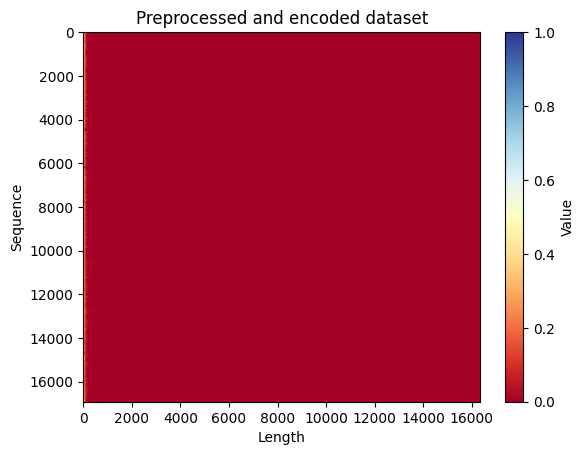

(16913, 16342)


In [6]:
def plot_patterns(data):
  plt.imshow(data, cmap='RdYlBu', aspect='auto')
  plt.colorbar(label='Value')
  plt.title('Preprocessed and encoded dataset')
  plt.xlabel('Length')
  plt.ylabel('Sequence')
  plt.show()


plot_patterns(input_data)
print(input_data.shape)

prep_data=input_data


###DAGMM


Epoch 0/50,TRAIN Loss: 231.3402 - TEST Loss: 14.8721
Epoch 10/50,TRAIN Loss: 3.0338 - TEST Loss: 1.3131
Epoch 20/50,TRAIN Loss: 1.7296 - TEST Loss: 0.8141
Epoch 30/50,TRAIN Loss: 0.9540 - TEST Loss: 0.4177
Epoch 40/50,TRAIN Loss: 0.4838 - TEST Loss: 0.2037


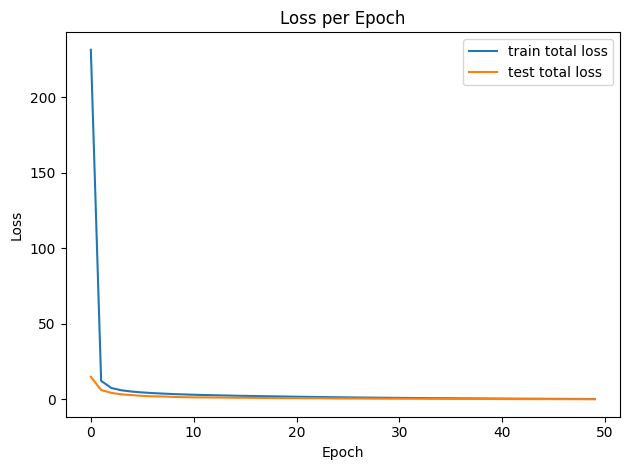

In [ ]:
import torch
import torch.nn as nn
import torch.optim as optim
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.cluster import KMeans
from torch.autograd import Variable
import tensorflow as tf


# Define Deep Autoencoder
class Autoencoder(nn.Module):
    def __init__(self, input_dim, hidden_dim1, hidden_dim2, hidden_dim3, latent_dim):
        super(Autoencoder, self).__init__()
        self.encoder = nn.Sequential(
            nn.Linear(input_dim, hidden_dim1),
            nn.Tanh(),
            nn.Linear(hidden_dim1, hidden_dim2),
            nn.Tanh(),
            nn.Linear(hidden_dim2, hidden_dim3),
            nn.Tanh(),
            nn.Linear(hidden_dim3, latent_dim-2)
        )
        self.decoder = nn.Sequential(
            nn.Linear(latent_dim-2, hidden_dim3),
            nn.Tanh(),
            nn.Linear(hidden_dim3, hidden_dim2),
            nn.Tanh(),
            nn.Linear(hidden_dim2, hidden_dim1),
            nn.Tanh(),
            nn.Linear(hidden_dim1, input_dim)
        )

    def forward(self, x):
        z = self.encoder(x)
        x_hat = self.decoder(z)
        return z, x_hat

# Define DAGMM Model
class DAGMM(nn.Module):
    def __init__(self, input_dim, hidden_dim1, hidden_dim2, hidden_dim3, latent_dim, n_gmm):
        super(DAGMM, self).__init__()
        self.autoencoder = Autoencoder(input_dim, hidden_dim1, hidden_dim2, hidden_dim3, latent_dim)
        self.estimation_network = nn.Sequential(
            nn.Linear(latent_dim, hidden_dim3),
            nn.Tanh(),
            nn.Dropout(p=0.5),
            nn.Linear(hidden_dim3, n_gmm),
            nn.Softmax(dim=1)
        )
        self.phi = torch.zeros(n_gmm)
        self.mu = torch.zeros(n_gmm,latent_dim)
        self.cov = torch.zeros(n_gmm, latent_dim, latent_dim)
        self.n_gmm=n_gmm
        self.latent_dim=latent_dim

    def relative_euclidean_distance(self, a, b):
        return (a-b).norm(2, dim=1) / a.norm(2, dim=1)

    def compute_cosine_similarity(self, x, x_hat):
        cosine_similarity = F.cosine_similarity(x, x_hat, dim=1)
        return cosine_similarity

    def cov_diag_loss(self):
        cov_inv = torch.zeros(self.cov.size(0), self.cov.size(1), self.cov.size(1), device=self.cov.device)
        det_cov = torch.zeros(self.cov.size(0), device=self.cov.device)
        cov_diag = 0
        for i in range(self.cov.size(0)):
            cov_k = self.cov[i].clone()
            cov_k += torch.diag(torch.full((self.cov.size(1),), 1e-12, device=self.cov.device))
            cov_inv[i] = torch.linalg.inv(cov_k)
            u, s, v = torch.svd(cov_k)
            det_cov[i] = s.prod() ** 2
            cov_diag += torch.sum(1 / cov_k.diag())

        return cov_diag, cov_inv, det_cov


    def forward(self, x):
        z, x_hat = self.autoencoder(x)
        rec_euclidean = self.relative_euclidean_distance(x, x_hat)
        cosine_similarity = self.compute_cosine_similarity(x,x_hat)
        z_with_errors = torch.cat([z, rec_euclidean.unsqueeze(-1), cosine_similarity.unsqueeze(-1)], dim=1)
        gamma = self.estimation_network(z_with_errors)
        return z, x_hat, z_with_errors, gamma


    def compute_energy(self, z):
        cov_diag, cov_inv, det_cov = self.cov_diag_loss()
        z_mu = (z.unsqueeze(1)- self.mu.unsqueeze(0))
        z_mu_cov_inv = torch.sum(z_mu.unsqueeze(-1) * cov_inv.unsqueeze(0), dim=-2)
        exp_term = torch.exp(-0.5 * torch.sum(z_mu_cov_inv * z_mu, dim=-1))
        positive_exp_term = (-0.5 * torch.sum(z_mu_cov_inv * z_mu, dim=-1)).clamp(min=0)
        max_positive_exp_term = torch.max(positive_exp_term, dim=1, keepdim=True)[0]
        energy = -max_positive_exp_term.squeeze() - torch.log(
            torch.sum(self.phi.unsqueeze(0) * exp_term / (torch.sqrt(det_cov)).unsqueeze(0), dim=1) + 1e-12
        )
        return energy



    def loss_function(self, x, lambda_energy, lambda_cov_diag):
        _, x_hat, z, gamma, = self(x)
        N = gamma.size(0)
        sum_gamma = torch.sum(gamma, dim=0)
        if model.training:
          self.phi = (sum_gamma / N)
          self.mu = torch.sum(gamma.unsqueeze(-1) * z.unsqueeze(1), dim=0) / sum_gamma.unsqueeze(-1)
          z_mu = (z.unsqueeze(1)- self.mu.unsqueeze(0))
          z_mu_outer = z_mu.unsqueeze(-1) * z_mu.unsqueeze(-2)
          self.cov = torch.sum(gamma.unsqueeze(-1).unsqueeze(-1) * z_mu_outer, dim = 0) / sum_gamma.unsqueeze(-1).unsqueeze(-1)
        sample_energy = self.compute_energy(z)
        loss = torch.mean((x - x_hat) ** 2) + lambda_energy * torch.mean(sample_energy) + lambda_cov_diag * self.cov_diag_loss()[0]
        return loss

    def get_energy(self, x,  torch_type=True):
        enc, dec, z, gamma = self(x)
        energy = self.compute_energy(z)
        ret_energy=energy.data.numpy()

        if torch_type == True:
          ret_energy=torch.from_numpy(ret_energy)

        return ret_energy


# Hyperparameters
input_dim = len(prep_data[0])
hidden_dim1 = 400
hidden_dim2 = 200
hidden_dim3 = 30
latent_dim = 3
n_gmm = 2
lr = 1e-4
epochs = 50
lambda_energy=0.1
lambda_cov_diag=0.005
batch_size = 1000

# Create model and optimizer
model = DAGMM(input_dim, hidden_dim1, hidden_dim2, hidden_dim3, latent_dim, n_gmm)
optimizer = optim.Adam(model.parameters(), lr=lr)

train_data, test_data = train_test_split(torch.tensor(prep_data, dtype=torch.float), test_size=0.25, random_state=40)
train_loader = torch.utils.data.DataLoader(train_data, batch_size=batch_size, shuffle=False)
test_loader = torch.utils.data.DataLoader(test_data, batch_size=batch_size, shuffle=False)

# Training function
def train(model, train_loader, test_loader, optimizer, num_epochs):
    train_losses = []
    test_losses = []
    for epoch in range(num_epochs):
        model.train()
        epoch_loss = 0.0
        epoch_loss_test = 0.0
        running_loss = 0.0
        test_running_loss=0.0
        count=0
        count_test=0
        for batch_idx, data in enumerate(train_loader):
            optimizer.zero_grad()
            total_loss = model.loss_function(data, lambda_energy, lambda_cov_diag)
            model.zero_grad()
            total_loss.backward()
            # torch.nn.utils.clip_grad_norm_(model.parameters(), 10)
            optimizer.step()
            running_loss += total_loss.item()

            loss = []
            loss.append( total_loss.item())
            count+=1
        epoch_loss=running_loss/count
        train_losses.append(epoch_loss)

        model.eval()
        with torch.no_grad():
            for batch_idx, data in enumerate(test_loader):
                test_loss = model.loss_function(data, lambda_energy, lambda_cov_diag)
                loss = []
                loss.append( test_loss.item())
                test_running_loss += test_loss.item()
                count_test+=1
        epoch_loss_test=test_running_loss/count_test
        test_losses.append(epoch_loss_test)
        if epoch%10 == 0:
          print(f"Epoch {epoch}/{num_epochs},TRAIN Loss: {epoch_loss:.4f} - TEST Loss: {epoch_loss_test:.4f}")
    return train_losses, test_losses


# Plotting function
def plot_losses(loss_data):
    plt.plot(loss_data[0], label="train total loss")
    plt.plot(loss_data[1], label="test total loss")
    plt.title('Loss per Epoch')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.legend()
    plt.tight_layout()
    # plt.ylim(loss_data[1][len(loss_data[0])-1]-2,loss_data[1][len(loss_data[0])-1]+2)
    plt.show()



# Train the model
losses = train(model, train_loader, test_loader, optimizer, epochs)

# Test the model
# test_losses = test(model, test_loader)

# avg_test_energy = sum(test_energy) / len(test_energy)

# Plot losses
plot_losses(losses)  # Broadcasting test loss to match training loss length
# print("Average Test Energy: ", avg_test_energy)
# plot_losses(test_losses)

threshold 7.4369771003724345
Detected 38 anomalies in test.
Detected 132 anomalies in train.


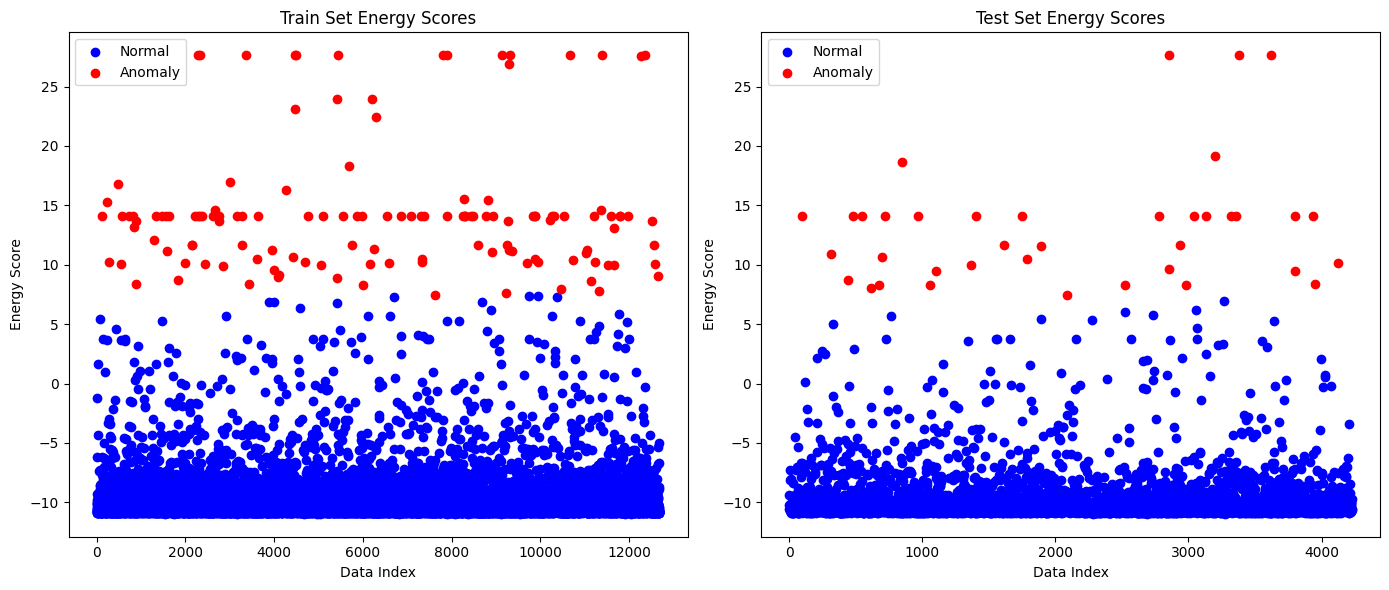

In [ ]:
import matplotlib.pyplot as plt

# Compute energy scores for train and test data
train_energy = model.get_energy(train_data)
test_energy = model.get_energy(test_data)

all_energy=np.concatenate((train_energy, test_energy), axis=0)

threshold = np.percentile(all_energy, 99)
print(f"threshold {threshold}")

anomaly_indices_test=torch.where(test_energy >= threshold)[0]

# anomaly_indices = (np.array(eval_energy) > threshold).astype(int)[0]
print(f"Detected {len(anomaly_indices_test)} anomalies in test.")

anomaly_indices_train=torch.where(train_energy >= threshold)[0]

# anomaly_indices = (np.array(eval_energy) > threshold).astype(int)[0]
print(f"Detected {len(anomaly_indices_train)} anomalies in train.")

# Create plots
plt.figure(figsize=(14, 6))

# Train set plot
plt.subplot(1, 2, 1)
normal_train_indices = torch.where(train_energy < threshold)[0]
anomaly_train_indices = torch.where(train_energy >= threshold)[0]
plt.scatter(normal_train_indices, train_energy[normal_train_indices], c='blue', label='Normal')
plt.scatter(anomaly_train_indices, train_energy[anomaly_train_indices], c='red', label='Anomaly')
plt.title('Train Set Energy Scores')
plt.xlabel('Data Index')
plt.ylabel('Energy Score')
plt.legend()

# Test set plot
plt.subplot(1, 2, 2)
normal_test_indices = torch.where(test_energy < threshold)[0]
anomaly_test_indices = torch.where(test_energy >= threshold)[0]
plt.scatter(normal_test_indices, test_energy[normal_test_indices], c='blue', label='Normal')
plt.scatter(anomaly_test_indices, test_energy[anomaly_test_indices], c='red', label='Anomaly')
plt.title('Test Set Energy Scores')
plt.xlabel('Data Index')
plt.ylabel('Energy Score')
plt.legend()


plt.tight_layout()
plt.show()

In [ ]:
# Find the index of the maximum energy score
max_energy_index = torch.argmax(train_energy)
print(train_energy[torch.argmax(train_energy)])

print("Index of the maximum energy score:", max_energy_index.item())
matching=train_data[max_energy_index]
matching_index = None
for i, node in enumerate(torch.tensor(prep_data, dtype=torch.float)):
    if np.array_equal(node, matching):
        matching_index = i
        break

flat_dataset = [item for sublist in dataset for item in sublist]
print("Index of matching node:", matching_index)
print("in dataset: ", flat_dataset[matching_index])

max_energy_index = torch.argmax(test_energy)
print(test_energy[max_energy_index])

print("Index of the maximum energy score:", max_energy_index.item())
matching=test_data[max_energy_index]
matching_index = None
for i, node in enumerate(torch.tensor(prep_data, dtype=torch.float)):
    if np.array_equal(node, matching):
        matching_index = i
        break

flat_dataset = [item for sublist in dataset for item in sublist]
print("Index of matching node:", matching_index)
print("in dataset: ", flat_dataset[matching_index])

tensor(27.6310)
Index of the maximum energy score: 2288
Index of matching node: 12733
in dataset:  {'BlockNumber': 17188127, 'TxHash': '0x23bd10c6b4543dbb18af4a9acc2ba8c7853fa1c39c2a7fb6437c6f257f74c380', 'CallList': [{'to': '0xd1917932a7db6af687b523d5db5d7f5c2734763f', 'from': '0xf5491f793d47a6ea22f5e0b9ad3990cf66c4b40b', 'value': '0.0', 'gas': '0.000000000001254641', 'input': '0xf6fff9bd'}, [{'to': '0xcfd68b6c4da7a17c494817e4994a7999e7dc830e', 'from': '0xd1917932a7db6af687b523d5db5d7f5c2734763f', 'value': '0.0', 'gas': '0.000000000001157437', 'input': '0xf6fff9bd'}, [{'to': '0xdac17f958d2ee523a2206206994597c13d831ec7', 'from': '0xd1917932a7db6af687b523d5db5d7f5c2734763f', 'value': '0.0', 'gas': '0.00000000000002653', 'input': '0x23b872dd'}, {'to': '0xdac17f958d2ee523a2206206994597c13d831ec7', 'from': '0xd1917932a7db6af687b523d5db5d7f5c2734763f', 'value': '0.0', 'gas': '0.000000000000011701', 'input': '0xa9059cbb'}, {'to': '0xdac17f958d2ee523a2206206994597c13d831ec7', 'from': '0xd1917

1
1
60
8514
SIZE
1
1042


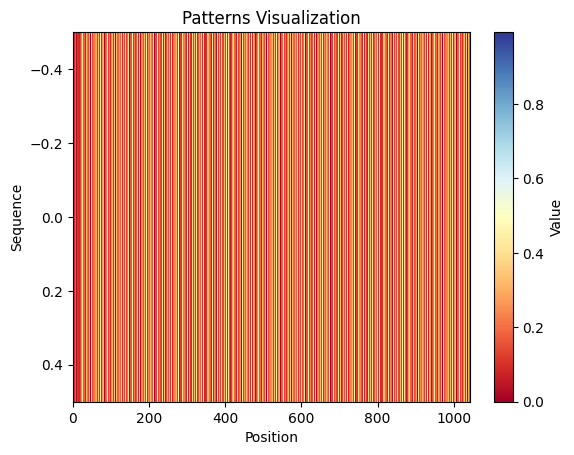

(1, 1042)
eval 1:  tensor([0.4095])


In [ ]:
with open('attackdata.json', 'r') as f:
    data = json.load(f)

anomally_dataset=data

anom1 = preprocess(anomally_dataset)

print(len(unnested_calls[0]))
print(len(anom1[0]))
anom_fin,_=encode(anom1, maxL)
anom = torch.tensor(anom_fin, dtype=torch.float)

def plot_patterns(data):
  plt.imshow(data, cmap='RdYlBu', aspect='auto')
  plt.colorbar(label='Value')
  plt.title('Patterns Visualization')
  plt.xlabel('Position')
  plt.ylabel('Sequence')
  plt.gca().yaxis.get_major_locator().set_params(integer=True)
  plt.show()


plot_patterns(anom_fin)
print(anom_fin.shape)

model.eval()  # Set the model to evaluation mode
with torch.no_grad():
  res1=model.get_energy(anom)


print("eval 1: ", res1)


In [ ]:
print(type(test_energy))

normal_energy=torch.cat((train_energy, test_energy), dim=0)

normal_indices = torch.where(normal_energy < threshold)[0]
anomaly_indices = torch.where(normal_energy >= threshold)[0]
attack = res1.detach()


plt.scatter(normal_indices, normal_energy[normal_indices], c='blue', label='Normal')
plt.scatter(anomaly_indices, normal_energy[anomaly_indices], c='cyan', label='Anomaly')
print(attack)
plt.scatter(range(1), attack[0], c='red', label='Attack')
plt.scatter(range(len(attack[1:3])), attack[1:3], c='lime', label='transactions on the same block as the attack')

plt.axhline(y=threshold, color='r', linestyle='--', label='Threshold')
plt.title('Energy Scores')
plt.xlabel('Data Index')
plt.ylabel('Energy Score')
plt.legend(loc='center left', bbox_to_anchor=(1, 0.5))

if(attack[0]>threshold):
  print("Found you")
else:
  print("try again")


<class 'torch.Tensor'>


NameError: name 'res1' is not defined

3504
3504
SIZE
3504
16342


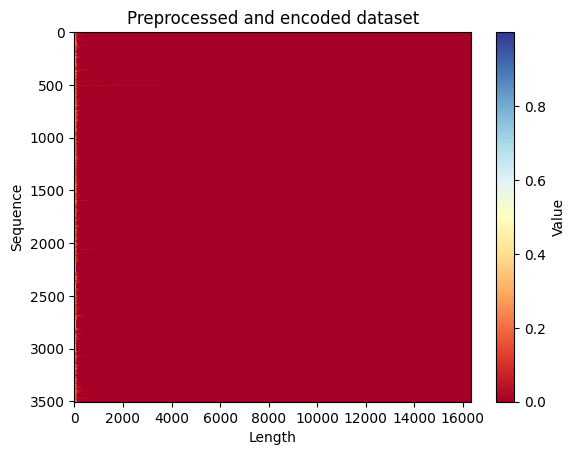

In [ ]:
with open('testdata6.json', 'r') as f:
    data = json.load(f)

example_dataset=data

# with open('attackdata.json', 'r') as f:
#     data = json.load(f)

# example_dataset+=[data]


exam1 = preprocess(example_dataset)

exam_fin, _=encode(exam1, maxL)
exam = torch.tensor(exam_fin, dtype=torch.float)



plot_patterns(exam_fin)

model.eval()  # Set the model to evaluation mode
with torch.no_grad():
  res2=model.get_energy(exam)



3504


[]

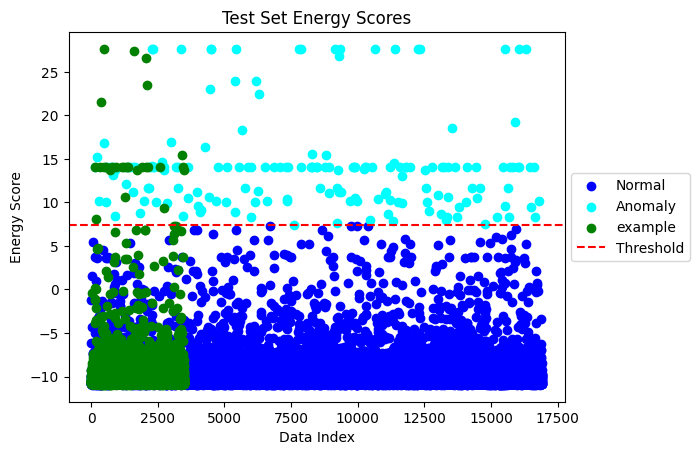

In [ ]:
example = res2.detach()
normal_energy=torch.cat((train_energy, test_energy), dim=0)

normal_indices = torch.where(normal_energy < threshold)[0]
anomaly_indices = torch.where(normal_energy >= threshold)[0]
plt.scatter(normal_indices, normal_energy[normal_indices], c='blue', label='Normal')
plt.scatter(anomaly_indices, normal_energy[anomaly_indices], c='cyan', label='Anomaly')
plt.scatter(range(len(example)), example, c='green', label='example')
print(len(example))

plt.axhline(y=threshold, color='r', linestyle='--', label='Threshold')
plt.legend(loc='center left', bbox_to_anchor=(1, 0.5))
plt.title('Test Set Energy Scores')
plt.xlabel('Data Index')
plt.ylabel('Energy Score')
plt.plot()


In [ ]:
max_energy_index = torch.argmax(example)
print("Index of the maximum energy score:", max_energy_index.item())
matching=example[max_energy_index].item()
matching_index = None
# for i, node in enumerate(torch.tensor(exam_fin, dtype=torch.float)):
#     if np.array_equal(node, matching):
#         matching_index = i
#         break

flat_dataset = [item for sublist in example_dataset for item in sublist]
print("Energy found:", matching)
if matching != None:
  print("in dataset: ", flat_dataset[max_energy_index])

Index of the maximum energy score: 503
Energy found: 27.63102149963379
in dataset:  {'BlockNumber': 17177568, 'TxHash': '0x5fddef35eafa646d866cd485147194764f159036737e95144562aa32d8799977', 'CallList': [{'to': '0xd1d61c7aabe6e08ba852e226430b73612d1b7366', 'from': '0x54a63836e920850f29eee0c98d1a2f851349451a', 'value': '0.0', 'gas': '0.000000000001350029', 'input': '0xa646f7d6'}, [{'to': '0x03b8f9edbf3eb3caa7b802fdc429439d712ec8f0', 'from': '0xd1d61c7aabe6e08ba852e226430b73612d1b7366', 'value': '0.0', 'gas': '0.000000000000045881', 'input': '0x32bf6e11c72a37b25d9f05f5b2d6c1a56269f84e9c68ae7e3c7c22b70fe5ccee'}, [{'to': '0xa9af78d2bfa0f8cdf2ff04d77367faacaf9f4e05', 'from': '0x03b8f9edbf3eb3caa7b802fdc429439d712ec8f0', 'value': '0.0', 'gas': '0.000000000000043212', 'input': '0x32bf6e11c72a37b25d9f05f5b2d6c1a56269f84e9c68ae7e3c7c22b70fe5ccee'}, [{'to': '0x68ef21a0168bcf753871e9fc26c86dd482cdd035', 'from': '0x03b8f9edbf3eb3caa7b802fdc429439d712ec8f0', 'value': '0.0', 'gas': '0.000000000000002

In [ ]:
def print_metrics(threshold, train_energy, test_energy, example):

  # print("the attack is found by the model: ", (attack[0] >= threshold).item())
  print("The threshold is: ", threshold)
  # print("The energy value of the attack is: ", attack[0])
  print("the highest energy in train is: ", train_energy[torch.argmax(train_energy)])
  print("the highest energy in test is: ", test_energy[torch.argmax(test_energy)])
  print("the highest energy in example is: ", example[torch.argmax(example)])

  print("------------------")

  print("number of transactions with energy greater or equal to the threshold in train is: ", len(torch.where(train_energy >= threshold)[0]), " out of: ", len(train_energy))
  print("number of transactions with energy greater or equal to the threshold in test is: ", len(torch.where(test_energy >= threshold)[0]), " out of: ", len(test_energy))
  print("number of transactions with energy greater or equal to the threshold in example is: ", len(torch.where(example >= threshold)[0]), " out of: ", len(example))

  # print("------------------")

  # print("number of transactions with energy greater or equal to the attack in train is: ", len(torch.where(train_energy >= attack[0])[0]), " out of: ", len(train_energy))
  # print("number of transactions with energy greater or equal to the attack in test is: ", len(torch.where(test_energy >= attack[0])[0]), " out of: ", len(test_energy))
  # print("number of transactions with energy greater or equal to the attack in example is: ", len(torch.where(example >= attack[0])[0]), " out of: ", len(example))

  print("------------------")

  print("average energy value in train is: ",torch.mean(train_energy))
  print("average energy value in test is: ",torch.mean(test_energy))
  print("average energy value in example is: ",torch.mean(example))

print_metrics(threshold, train_energy, test_energy, example)

The threshold is:  25
the highest energy in train is:  tensor(27.6310)
the highest energy in test is:  tensor(27.6310)
the highest energy in example is:  tensor(27.6310)
------------------
number of transactions with energy greater or equal to the threshold in train is:  12  out of:  12684
number of transactions with energy greater or equal to the threshold in test is:  3  out of:  4229
number of transactions with energy greater or equal to the threshold in example is:  2  out of:  3504
------------------
average energy value in train is:  tensor(-10.7923)
average energy value in test is:  tensor(-10.7493)
average energy value in example is:  tensor(-10.9564)


###without attack

In [ ]:
true_pos_arr=[[],[],[],[],[],[],[]]
false_pos_arr=[[],[],[],[],[],[],[]]
true_neg_arr=[[],[],[],[],[],[],[]]
false_neg_arr=[[],[],[],[],[],[],[]]

def mean(lst):
    if not lst:
        return None  # Handle empty list case
    return sum(lst) / len(lst)

def stats(example, threshold):
  res=[]
  for thres in threshold:
    false_pos=len(torch.where(example >= thres)[0])/len(example)
    true_neg=len(torch.where(example < thres)[0])/len(example)
    res.append([ true_neg, false_pos])

  return res

threshold = [np.percentile(all_energy, 99.99),np.percentile(all_energy, 99.9),np.percentile(all_energy, 99.5),np.percentile(all_energy, 99),np.percentile(all_energy, 95),np.percentile(all_energy, 90),np.percentile(all_energy, 75)]
ftpn=stats(example, threshold)
count=0
for res in ftpn:
  print("True negative: ", res[0])
  print("False possitive: ", res[1])
  true_neg_arr[count]=res[0]
  false_pos_arr[count]=res[1]
  count+=1

thresholds=[0.01, 0.1, 0.5, 1, 5, 10, 25]
print("__________")
count=0
for tr in thresholds:
  print("For threshold = ", tr)
  print("True negative: ", true_neg_arr[count])
  print("False possitive: ", false_pos_arr[count])
  count+=1



True negative:  0.9997146118721462
False possitive:  0.00028538812785388126
True negative:  0.9994292237442922
False possitive:  0.0005707762557077625
True negative:  0.995148401826484
False possitive:  0.0048515981735159815
True negative:  0.990296803652968
False possitive:  0.009703196347031963
True negative:  0.9551940639269406
False possitive:  0.04480593607305936
True negative:  0.9335045662100456
False possitive:  0.06649543378995434
True negative:  0.7945205479452054
False possitive:  0.2054794520547945
__________
For threshold =  0.01
True negative:  0.9997146118721462
False possitive:  0.00028538812785388126
For threshold =  0.1
True negative:  0.9994292237442922
False possitive:  0.0005707762557077625
For threshold =  0.5
True negative:  0.995148401826484
False possitive:  0.0048515981735159815
For threshold =  1
True negative:  0.990296803652968
False possitive:  0.009703196347031963
For threshold =  5
True negative:  0.9551940639269406
False possitive:  0.04480593607305936


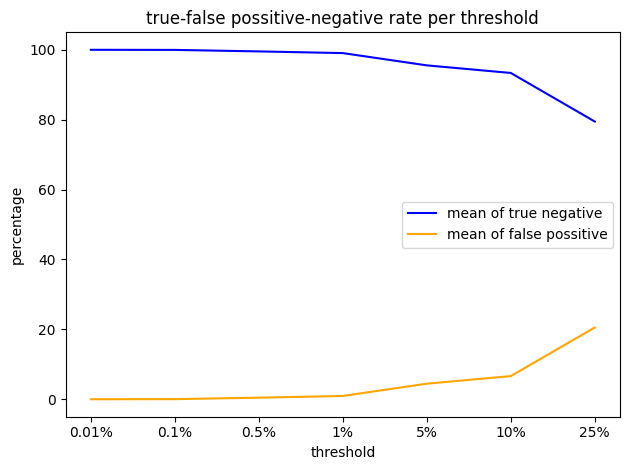

In [ ]:
  mtn=[]
  mfp=[]
  t=["0.01%", "0.1%", "0.5%", "1%", "5%", "10%", "25%"]
  count=0
  for tr in threshold:
    mtn.append(true_neg_arr[count]*100)
    mfp.append(false_pos_arr[count]*100)
    count+=1

  plt.plot(t, mtn, label="mean of true negative", c='blue')
  plt.plot(t, mfp, label="mean of false possitive", c='orange')
  plt.title('true-false possitive-negative rate per threshold')
  plt.xlabel('threshold')
  plt.ylabel('percentage')
  plt.legend()
  plt.tight_layout()
  # plt.ylim(loss_data[1][len(loss_data[0])-1]-2,loss_data[1][len(loss_data[0])-1]+2)
  plt.show()


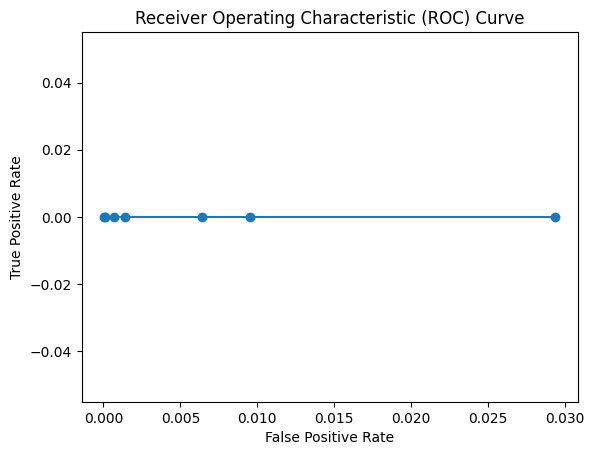

In [ ]:
total_positives = sum(mtn) + sum(mfp)
total_negatives = sum(mtn) + sum(mfp)

# Calculate TPR and FPR
TPR = [0 / total_positives for tp in mfp]
FPR = [fp / total_negatives for fp in mfp]

# Plotting the ROC curve
plt.plot(FPR, TPR, marker='o')


# Adding labels and title
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve')

# Displaying the plot
plt.show()

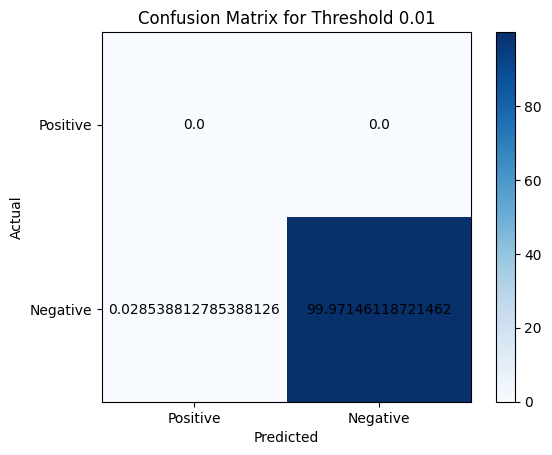

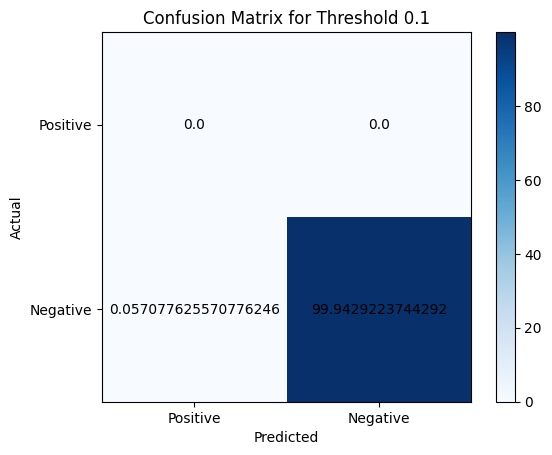

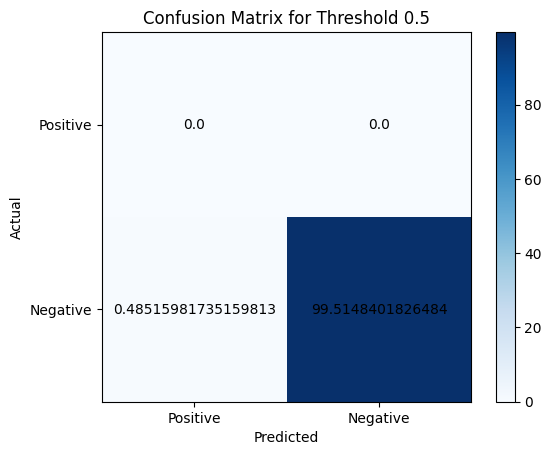

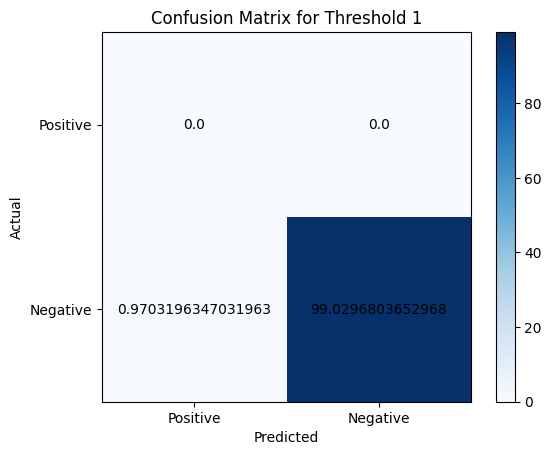

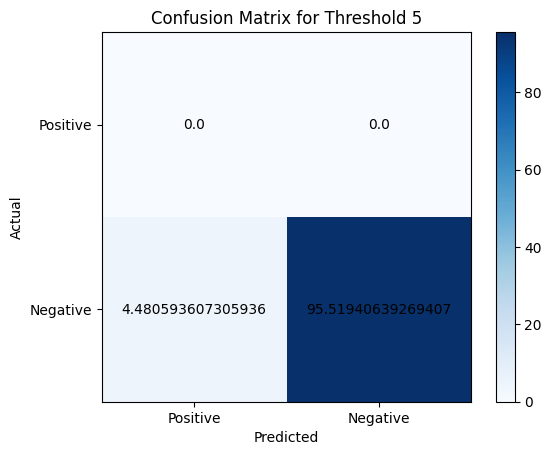

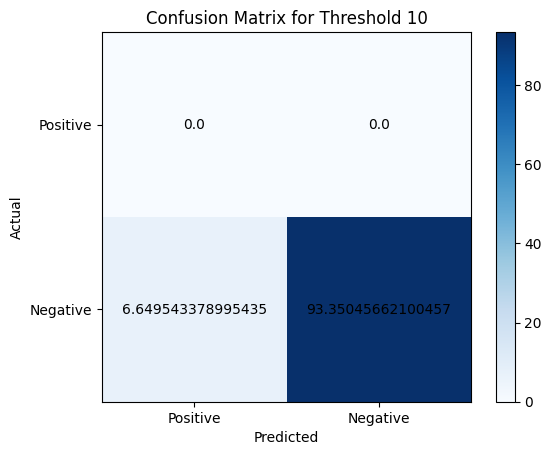

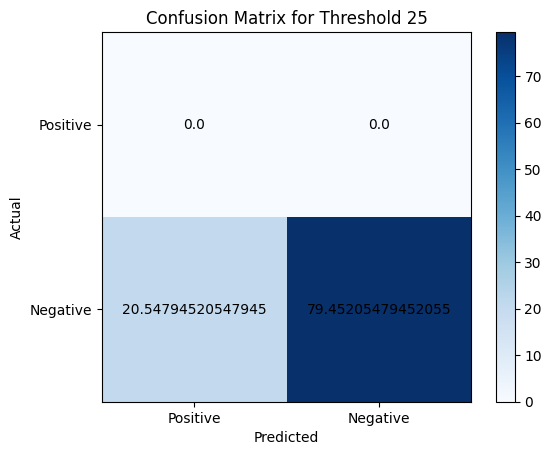

In [ ]:
# Sample percentages of TP, TN, FP, FN for different thresholds


for i, threshold in enumerate(thresholds):

    total_negatives = mtn[i] + mfp[i]

    # Calculate TP, TN, FP, FN
    TP = 0.0
    TN = mtn[i] / 100 * total_negatives
    FP = mfp[i] / 100 * total_negatives
    FN = 0.0

    # Creating confusion matrix
    confusion_matrix = np.array([[TP, FN], [FP, TN]])

    # Plotting the confusion matrix
    plt.figure()
    plt.imshow(confusion_matrix, cmap=plt.cm.Blues, interpolation='nearest')
    plt.colorbar()

    # Adding labels
    plt.title(f'Confusion Matrix for Threshold {threshold}')
    plt.ylabel('Actual')
    plt.xlabel('Predicted')
    plt.xticks([0, 1], ['Positive', 'Negative'])
    plt.yticks([0, 1], ['Positive', 'Negative'])

    # Displaying the plot
    for i in range(len(confusion_matrix)):
        for j in range(len(confusion_matrix[0])):
            plt.text(j, i, str(confusion_matrix[i, j]), va='center', ha='center')

plt.show()


###True False

In i=  0
Epoch 0/100,TRAIN Loss: 25.2674 - TEST Loss: 4.0022
Epoch 10/100,TRAIN Loss: 0.1249 - TEST Loss: -0.0840
Epoch 20/100,TRAIN Loss: -0.5902 - TEST Loss: -0.6719
Epoch 30/100,TRAIN Loss: -0.7660 - TEST Loss: -0.7937
Epoch 40/100,TRAIN Loss: -0.8247 - TEST Loss: -0.7916
Epoch 50/100,TRAIN Loss: -0.8766 - TEST Loss: -0.7950
Epoch 60/100,TRAIN Loss: -0.8980 - TEST Loss: -0.8466
Epoch 70/100,TRAIN Loss: -0.9354 - TEST Loss: -0.8700
Epoch 80/100,TRAIN Loss: -0.9218 - TEST Loss: -0.9114
Epoch 90/100,TRAIN Loss: -0.9174 - TEST Loss: -0.8781


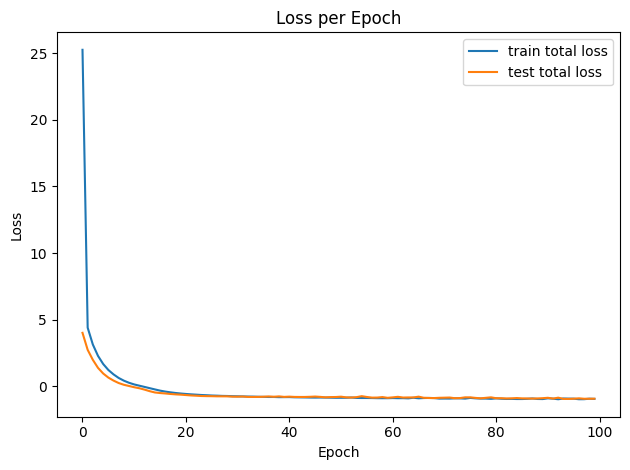

186
186
SIZE
186
1042
1
1
SIZE
1
1042
True possitive:  0.0
True negative:  0.9838709677419355
False possitive:  0.016129032258064516
False negative:  1.0
True possitive:  0.0
True negative:  0.9838709677419355
False possitive:  0.016129032258064516
False negative:  1.0
True possitive:  0.0
True negative:  0.9838709677419355
False possitive:  0.016129032258064516
False negative:  1.0
True possitive:  0.0
True negative:  0.9731182795698925
False possitive:  0.026881720430107527
False negative:  1.0
True possitive:  1.0
True negative:  0.9247311827956989
False possitive:  0.07526881720430108
False negative:  0.0
True possitive:  1.0
True negative:  0.8817204301075269
False possitive:  0.11827956989247312
False negative:  0.0
True possitive:  1.0
True negative:  0.7258064516129032
False possitive:  0.27419354838709675
False negative:  0.0
In i=  1
Epoch 0/100,TRAIN Loss: 30.5592 - TEST Loss: 9.9899
Epoch 10/100,TRAIN Loss: 0.3092 - TEST Loss: 0.6461
Epoch 20/100,TRAIN Loss: -0.5058 - TEST 

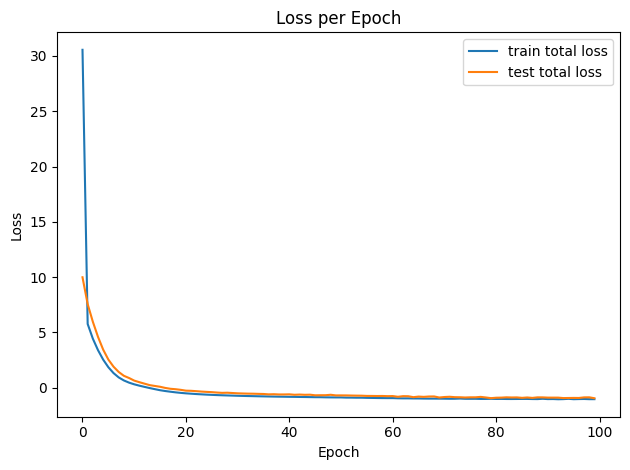

186
186
SIZE
186
1042
1
1
SIZE
1
1042
True possitive:  1.0
True negative:  0.9838709677419355
False possitive:  0.016129032258064516
False negative:  0.0
True possitive:  1.0
True negative:  0.9838709677419355
False possitive:  0.016129032258064516
False negative:  0.0
True possitive:  1.0
True negative:  0.9838709677419355
False possitive:  0.016129032258064516
False negative:  0.0
True possitive:  1.0
True negative:  0.9838709677419355
False possitive:  0.016129032258064516
False negative:  0.0
True possitive:  1.0
True negative:  0.946236559139785
False possitive:  0.053763440860215055
False negative:  0.0
True possitive:  1.0
True negative:  0.9032258064516129
False possitive:  0.0967741935483871
False negative:  0.0
True possitive:  1.0
True negative:  0.7526881720430108
False possitive:  0.24731182795698925
False negative:  0.0
In i=  2
Epoch 0/100,TRAIN Loss: 41.5965 - TEST Loss: 6.2392
Epoch 10/100,TRAIN Loss: 1.0260 - TEST Loss: 0.5595
Epoch 20/100,TRAIN Loss: -0.0437 - TEST L

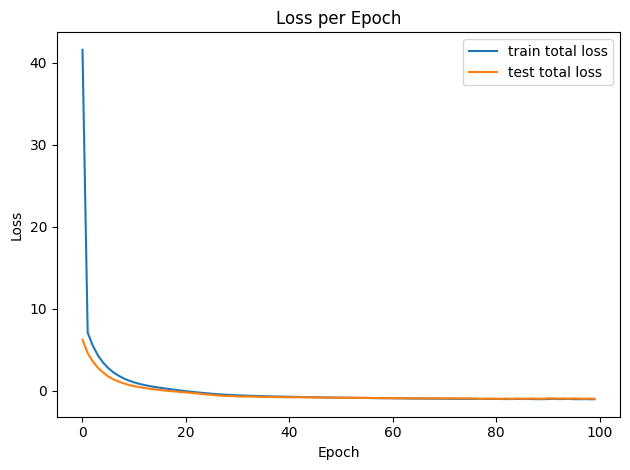

186
186
SIZE
186
1042
1
1
SIZE
1
1042
True possitive:  1.0
True negative:  0.989247311827957
False possitive:  0.010752688172043012
False negative:  0.0
True possitive:  1.0
True negative:  0.989247311827957
False possitive:  0.010752688172043012
False negative:  0.0
True possitive:  1.0
True negative:  0.978494623655914
False possitive:  0.021505376344086023
False negative:  0.0
True possitive:  1.0
True negative:  0.978494623655914
False possitive:  0.021505376344086023
False negative:  0.0
True possitive:  1.0
True negative:  0.9139784946236559
False possitive:  0.08602150537634409
False negative:  0.0
True possitive:  1.0
True negative:  0.8602150537634409
False possitive:  0.13978494623655913
False negative:  0.0
True possitive:  1.0
True negative:  0.7473118279569892
False possitive:  0.25268817204301075
False negative:  0.0
In i=  3
Epoch 0/100,TRAIN Loss: 26.5224 - TEST Loss: 6.1281
Epoch 10/100,TRAIN Loss: 0.2488 - TEST Loss: 0.3854
Epoch 20/100,TRAIN Loss: -0.5605 - TEST Loss

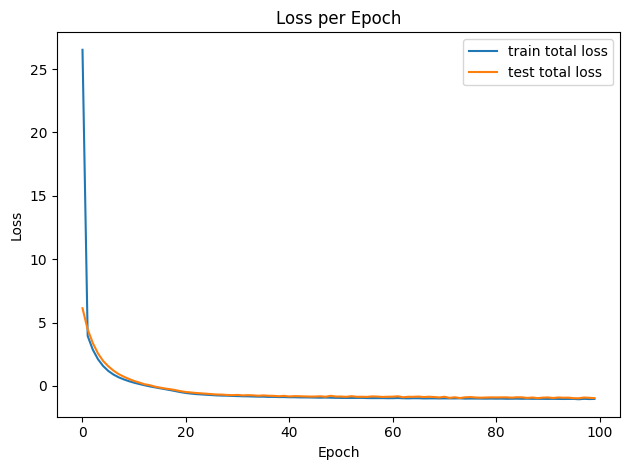

186
186
SIZE
186
1042
1
1
SIZE
1
1042
True possitive:  1.0
True negative:  0.9838709677419355
False possitive:  0.016129032258064516
False negative:  0.0
True possitive:  1.0
True negative:  0.9838709677419355
False possitive:  0.016129032258064516
False negative:  0.0
True possitive:  1.0
True negative:  0.9838709677419355
False possitive:  0.016129032258064516
False negative:  0.0
True possitive:  1.0
True negative:  0.9731182795698925
False possitive:  0.026881720430107527
False negative:  0.0
True possitive:  1.0
True negative:  0.9193548387096774
False possitive:  0.08064516129032258
False negative:  0.0
True possitive:  1.0
True negative:  0.8602150537634409
False possitive:  0.13978494623655913
False negative:  0.0
True possitive:  1.0
True negative:  0.7311827956989247
False possitive:  0.26881720430107525
False negative:  0.0
In i=  4
Epoch 0/100,TRAIN Loss: 39.1785 - TEST Loss: 5.7045
Epoch 10/100,TRAIN Loss: 0.7104 - TEST Loss: 0.5332
Epoch 20/100,TRAIN Loss: -0.1520 - TEST 

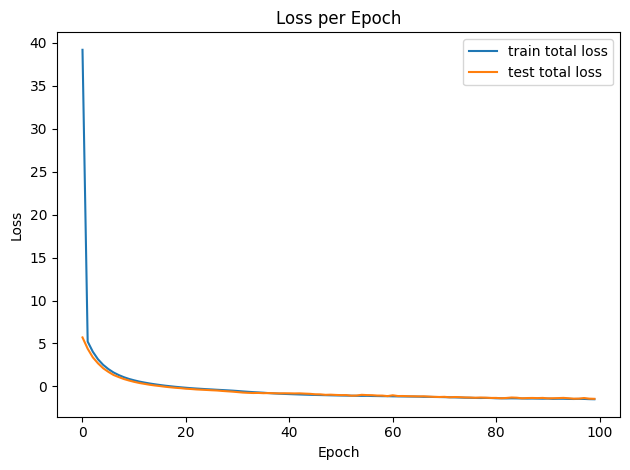

186
186
SIZE
186
1042
1
1
SIZE
1
1042
True possitive:  1.0
True negative:  1.0
False possitive:  0.0
False negative:  0.0
True possitive:  1.0
True negative:  0.9946236559139785
False possitive:  0.005376344086021506
False negative:  0.0
True possitive:  1.0
True negative:  0.9838709677419355
False possitive:  0.016129032258064516
False negative:  0.0
True possitive:  1.0
True negative:  0.967741935483871
False possitive:  0.03225806451612903
False negative:  0.0
True possitive:  1.0
True negative:  0.9408602150537635
False possitive:  0.05913978494623656
False negative:  0.0
True possitive:  1.0
True negative:  0.8709677419354839
False possitive:  0.12903225806451613
False negative:  0.0
True possitive:  1.0
True negative:  0.7526881720430108
False possitive:  0.24731182795698925
False negative:  0.0
In i=  5
Epoch 0/100,TRAIN Loss: 35.0469 - TEST Loss: 4.1756
Epoch 10/100,TRAIN Loss: 0.4089 - TEST Loss: 0.0706
Epoch 20/100,TRAIN Loss: -0.1112 - TEST Loss: -0.2211
Epoch 30/100,TRAIN L

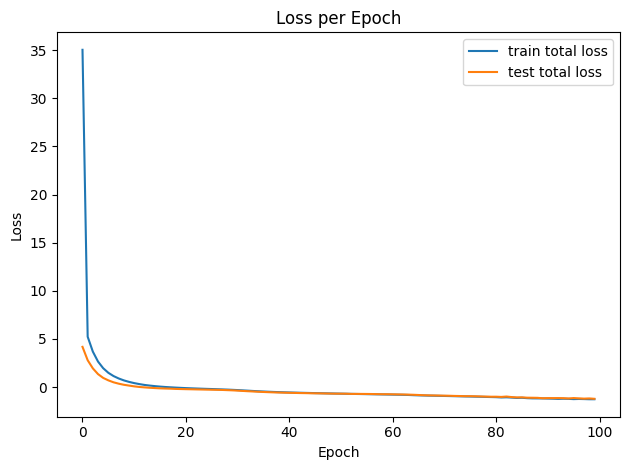

186
186
SIZE
186
1042
1
1
SIZE
1
1042
True possitive:  1.0
True negative:  1.0
False possitive:  0.0
False negative:  0.0
True possitive:  1.0
True negative:  1.0
False possitive:  0.0
False negative:  0.0
True possitive:  1.0
True negative:  0.9838709677419355
False possitive:  0.016129032258064516
False negative:  0.0
True possitive:  1.0
True negative:  0.967741935483871
False possitive:  0.03225806451612903
False negative:  0.0
True possitive:  1.0
True negative:  0.9193548387096774
False possitive:  0.08064516129032258
False negative:  0.0
True possitive:  1.0
True negative:  0.8870967741935484
False possitive:  0.11290322580645161
False negative:  0.0
True possitive:  1.0
True negative:  0.7365591397849462
False possitive:  0.26344086021505375
False negative:  0.0
In i=  6
Epoch 0/100,TRAIN Loss: 29.8727 - TEST Loss: 3.7531
Epoch 10/100,TRAIN Loss: 0.7179 - TEST Loss: 0.3417
Epoch 20/100,TRAIN Loss: 0.1660 - TEST Loss: 0.0445
Epoch 30/100,TRAIN Loss: -0.0185 - TEST Loss: -0.0747


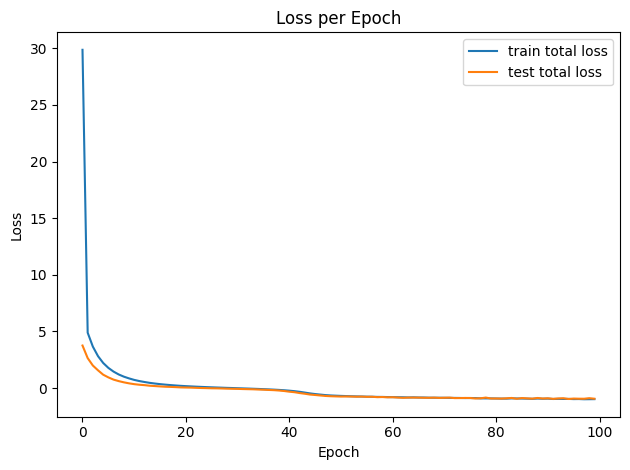

186
186
SIZE
186
1042
1
1
SIZE
1
1042
True possitive:  1.0
True negative:  1.0
False possitive:  0.0
False negative:  0.0
True possitive:  1.0
True negative:  1.0
False possitive:  0.0
False negative:  0.0
True possitive:  1.0
True negative:  0.9838709677419355
False possitive:  0.016129032258064516
False negative:  0.0
True possitive:  1.0
True negative:  0.9731182795698925
False possitive:  0.026881720430107527
False negative:  0.0
True possitive:  1.0
True negative:  0.9193548387096774
False possitive:  0.08064516129032258
False negative:  0.0
True possitive:  1.0
True negative:  0.8870967741935484
False possitive:  0.11290322580645161
False negative:  0.0
True possitive:  1.0
True negative:  0.7419354838709677
False possitive:  0.25806451612903225
False negative:  0.0
In i=  7
Epoch 0/100,TRAIN Loss: 33.4993 - TEST Loss: 6.0921
Epoch 10/100,TRAIN Loss: 0.4543 - TEST Loss: 0.4637
Epoch 20/100,TRAIN Loss: -0.0533 - TEST Loss: -0.0115
Epoch 30/100,TRAIN Loss: -0.5950 - TEST Loss: -0.6

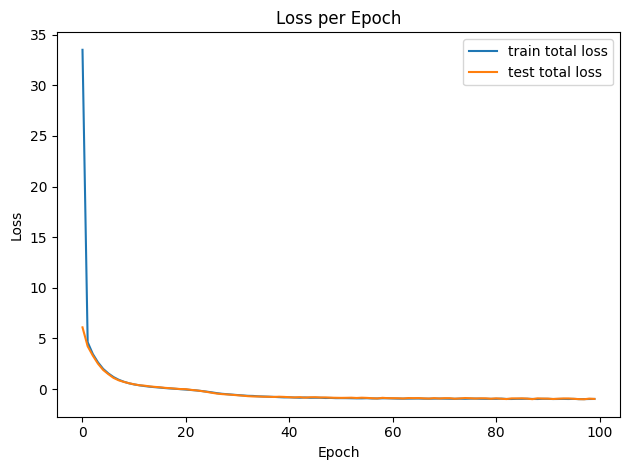

186
186
SIZE
186
1042
1
1
SIZE
1
1042
True possitive:  0.0
True negative:  1.0
False possitive:  0.0
False negative:  1.0
True possitive:  0.0
True negative:  0.9946236559139785
False possitive:  0.005376344086021506
False negative:  1.0
True possitive:  1.0
True negative:  0.9838709677419355
False possitive:  0.016129032258064516
False negative:  0.0
True possitive:  1.0
True negative:  0.9731182795698925
False possitive:  0.026881720430107527
False negative:  0.0
True possitive:  1.0
True negative:  0.9354838709677419
False possitive:  0.06451612903225806
False negative:  0.0
True possitive:  1.0
True negative:  0.8709677419354839
False possitive:  0.12903225806451613
False negative:  0.0
True possitive:  1.0
True negative:  0.7580645161290323
False possitive:  0.24193548387096775
False negative:  0.0
In i=  8
Epoch 0/100,TRAIN Loss: 28.3705 - TEST Loss: 7.3111
Epoch 10/100,TRAIN Loss: 0.4580 - TEST Loss: 0.8713
Epoch 20/100,TRAIN Loss: -0.1633 - TEST Loss: -0.1587
Epoch 30/100,TRAIN

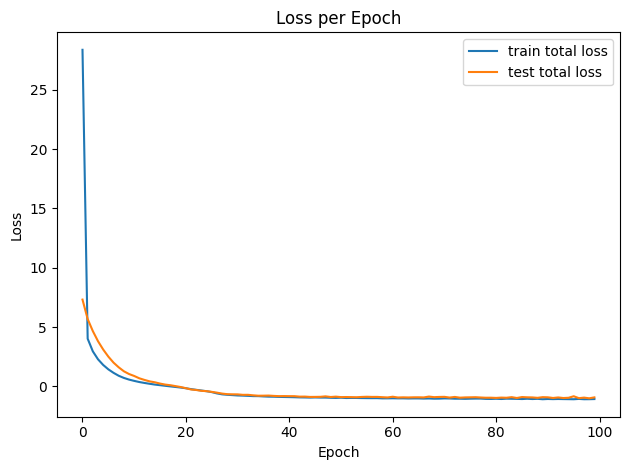

186
186
SIZE
186
1042
1
1
SIZE
1
1042
True possitive:  1.0
True negative:  0.9838709677419355
False possitive:  0.016129032258064516
False negative:  0.0
True possitive:  1.0
True negative:  0.9838709677419355
False possitive:  0.016129032258064516
False negative:  0.0
True possitive:  1.0
True negative:  0.9838709677419355
False possitive:  0.016129032258064516
False negative:  0.0
True possitive:  1.0
True negative:  0.9838709677419355
False possitive:  0.016129032258064516
False negative:  0.0
True possitive:  1.0
True negative:  0.9086021505376344
False possitive:  0.0913978494623656
False negative:  0.0
True possitive:  1.0
True negative:  0.8440860215053764
False possitive:  0.15591397849462366
False negative:  0.0
True possitive:  1.0
True negative:  0.7365591397849462
False possitive:  0.26344086021505375
False negative:  0.0
In i=  9
Epoch 0/100,TRAIN Loss: 66.4544 - TEST Loss: 8.4165
Epoch 10/100,TRAIN Loss: 1.2048 - TEST Loss: 0.4628
Epoch 20/100,TRAIN Loss: 0.1944 - TEST Lo

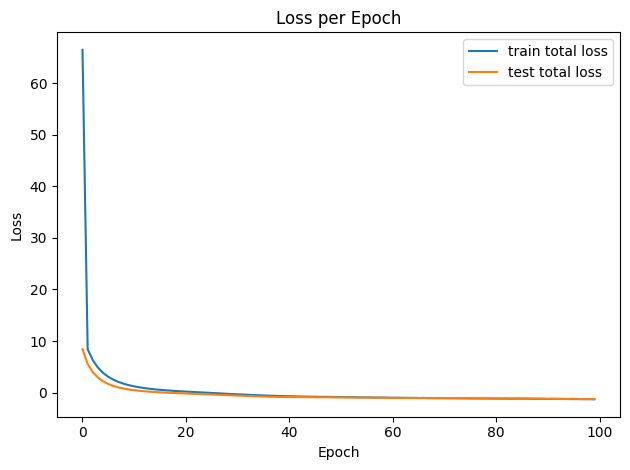

186
186
SIZE
186
1042
1
1
SIZE
1
1042
True possitive:  0.0
True negative:  1.0
False possitive:  0.0
False negative:  1.0
True possitive:  1.0
True negative:  0.989247311827957
False possitive:  0.010752688172043012
False negative:  0.0
True possitive:  1.0
True negative:  0.989247311827957
False possitive:  0.010752688172043012
False negative:  0.0
True possitive:  1.0
True negative:  0.978494623655914
False possitive:  0.021505376344086023
False negative:  0.0
True possitive:  1.0
True negative:  0.9086021505376344
False possitive:  0.0913978494623656
False negative:  0.0
True possitive:  1.0
True negative:  0.8440860215053764
False possitive:  0.15591397849462366
False negative:  0.0
True possitive:  1.0
True negative:  0.7473118279569892
False possitive:  0.25268817204301075
False negative:  0.0

Results after 10 model trains
_____________________________
For threshold =  0.01
False possitive:  0.7
True possitive:  0.007526881720430108
False negative:  0.99247311827957
True negativ

In [ ]:
input_dim = len(prep_data[0])
hidden_dim1 = 400
hidden_dim2 = 200
hidden_dim3 = 30
latent_dim = 3
n_gmm = 5
lr = 1e-4
epochs = 100
lambda_energy=0.1
lambda_cov_diag=0.005
batch_size = 60

true_pos_arr=[[],[],[],[],[],[],[]]
false_pos_arr=[[],[],[],[],[],[],[]]
true_neg_arr=[[],[],[],[],[],[],[]]
false_neg_arr=[[],[],[],[],[],[],[]]

def mean(lst):
    if not lst:
        return None  # Handle empty list case
    return sum(lst) / len(lst)

def stats(example, attack, threshold):
  res=[]
  for thres in threshold:
    false_pos=len(torch.where(example >= thres)[0])/len(example)
    true_pos=len(torch.where(attack >= thres)[0])/len(attack)
    false_neg=len(torch.where(attack < thres)[0])/len(attack)
    true_neg=len(torch.where(example < thres)[0])/len(example)
    res.append([true_pos, true_neg, false_pos, false_neg])

  return res



def train_model(model, prep_data, optimizer, epochs):
  train_data, test_data = train_test_split(torch.tensor(prep_data, dtype=torch.float), test_size=0.25)
  train_loader = torch.utils.data.DataLoader(train_data, batch_size=batch_size, shuffle=False)
  test_loader = torch.utils.data.DataLoader(test_data, batch_size=batch_size, shuffle=False)


  losses = train(model, train_loader, test_loader, optimizer, epochs)
  plot_losses(losses)
  model.eval()  # Set the model to evaluation mode
  with torch.no_grad():
    train_energy = model.get_energy(train_data)
    test_energy = model.get_energy(test_data)

    all_energy=np.concatenate((train_energy, test_energy), axis=0)

    threshold = [np.percentile(all_energy, 99.99),np.percentile(all_energy, 99.9),np.percentile(all_energy, 99.5),np.percentile(all_energy, 99),np.percentile(all_energy, 95),np.percentile(all_energy, 90),np.percentile(all_energy, 75)]

    with open('testdata6.json', 'r') as f:
      data = json.load(f)

    example_dataset=data
    exam1 = preprocess(example_dataset)
    exam_fin, _=encode(exam1, maxL)
    exam = torch.tensor(exam_fin, dtype=torch.float)
    res2=model.get_energy(exam)
    example = res2.detach()
    with open('attackdata.json', 'r') as f:
      data = json.load(f)
    anomally_dataset=data
    anom1 = preprocess(anomally_dataset)
    anom_fin,_=encode(anom1, maxL)
    anom = torch.tensor(anom_fin, dtype=torch.float)
    res1=model.get_energy(anom)
    attack = res1.detach()

    ftpn=stats(example, torch.tensor([attack[0]], dtype=torch.float), threshold)
    return ftpn
i=0
while(i<10):
  print("In i= ", i)
  model = DAGMM(input_dim, hidden_dim1, hidden_dim2, hidden_dim3, latent_dim, n_gmm)
  optimizer = optim.Adam(model.parameters(), lr=lr)
  results = train_model(model, prep_data, optimizer, epochs)
  count=0
  for res in results:
    print("True possitive: ", res[0])
    print("True negative: ", res[1])
    print("False possitive: ", res[2])
    print("False negative: ", res[3])
    true_pos_arr[count].append(res[0])
    true_neg_arr[count].append(res[1])
    false_pos_arr[count].append(res[2])
    false_neg_arr[count].append(res[3])
    count+=1
  i+=1
thresholds=[0.01, 0.1, 0.5, 1, 5, 10, 25]
print()
print("Results after 10 model trains")
print("_____________________________")
count=0
for tr in thresholds:
  print("For threshold = ", tr)
  print("False possitive: ", mean(true_pos_arr[count]))
  print("True possitive: ", mean(false_pos_arr[count]))
  print("False negative: ", mean(true_neg_arr[count]))
  print("True negative: ", mean(false_neg_arr[count]))
  count+=1




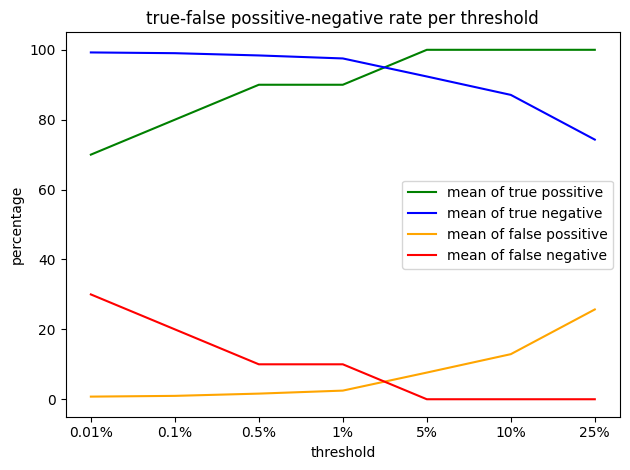

In [ ]:
  mtp=[]
  mfp=[]
  mtn=[]
  mfn=[]
  t=["0.01%", "0.1%", "0.5%", "1%", "5%", "10%", "25%"]
  count=0
  for tr in thresholds:
    mtp.append(mean(true_pos_arr[count])*100)
    mtn.append(mean(true_neg_arr[count])*100)
    mfp.append(mean(false_pos_arr[count])*100)
    mfn.append(mean(false_neg_arr[count])*100)
    count+=1

  plt.plot(t, mtp, label="mean of true possitive", c='green')
  plt.plot(t, mtn, label="mean of true negative", c='blue')
  plt.plot(t, mfp, label="mean of false possitive", c='orange')
  plt.plot(t, mfn, label="mean of false negative", c='red')
  plt.title('true-false possitive-negative rate per threshold')
  plt.xlabel('threshold')
  plt.ylabel('percentage')
  plt.legend()
  plt.tight_layout()
  # plt.ylim(loss_data[1][len(loss_data[0])-1]-2,loss_data[1][len(loss_data[0])-1]+2)
  plt.show()


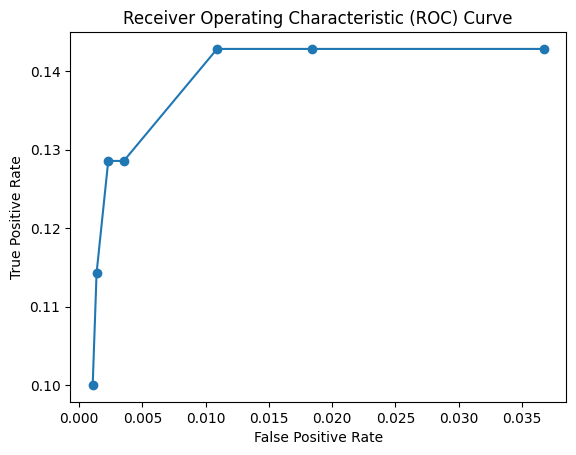

In [ ]:

total_positives = sum(mtp) + sum(mfn)
total_negatives = sum(mtn) + sum(mfp)

# Calculate TPR and FPR
TPR = [tp / total_positives for tp in mtp]
FPR = [fp / total_negatives for fp in mfp]

# Plotting the ROC curve
plt.plot(FPR, TPR, marker='o')


# Adding labels and title
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve')

# Displaying the plot
plt.show()

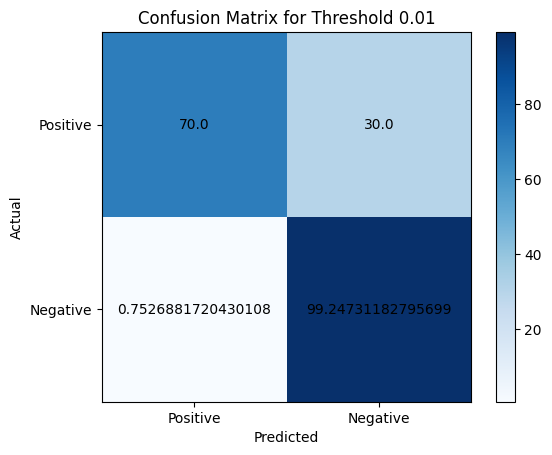

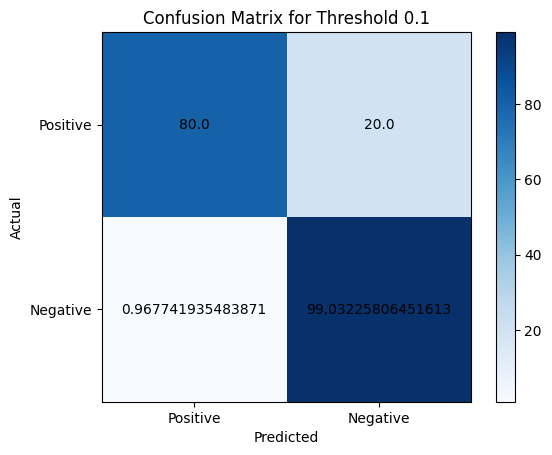

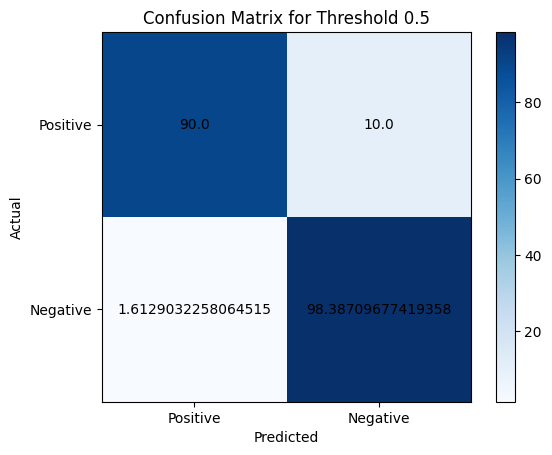

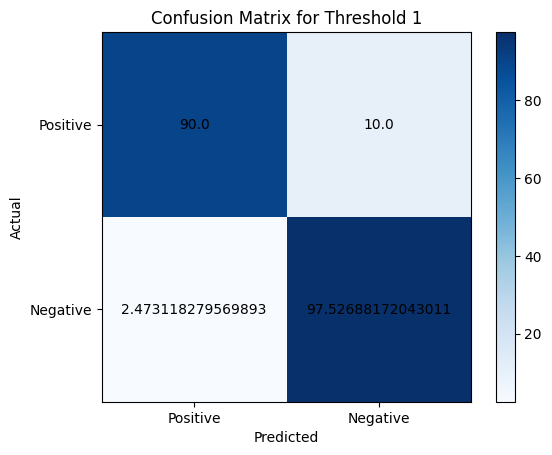

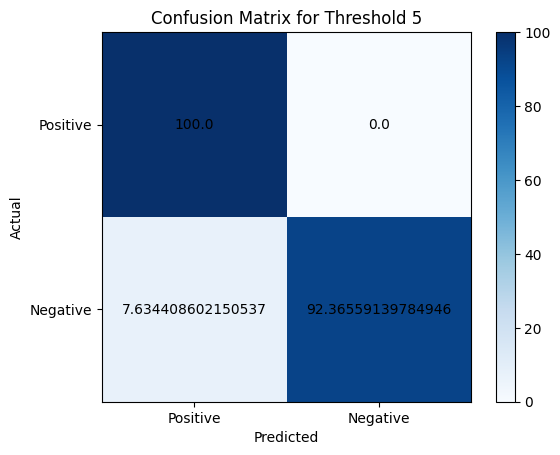

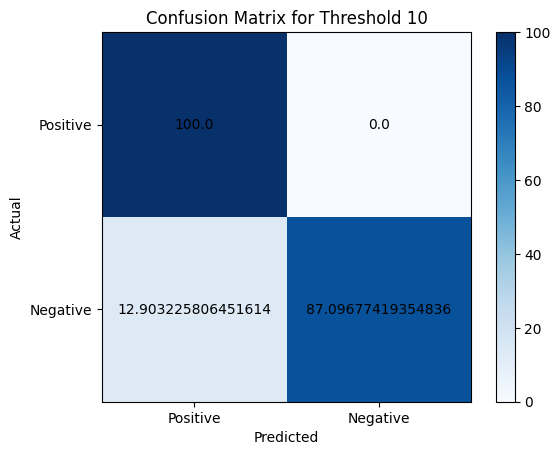

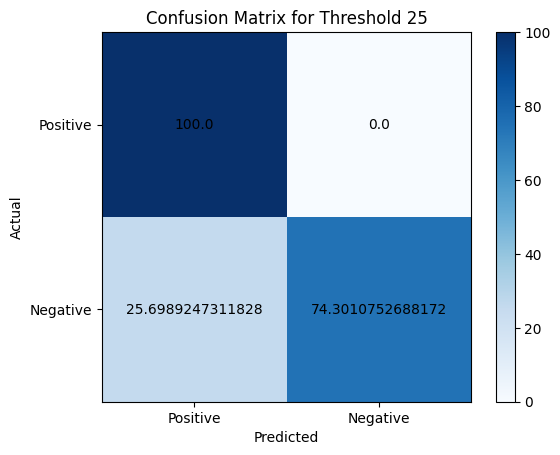

In [ ]:
# Sample percentages of TP, TN, FP, FN for different thresholds


for i, threshold in enumerate(thresholds):

    total_positives = mtp[i] + mfn[i]
    total_negatives = mtn[i] + mfp[i]

    # Calculate TP, TN, FP, FN
    TP = mtp[i] / 100 * total_positives
    TN = mtn[i] / 100 * total_negatives
    FP = mfp[i] / 100 * total_negatives
    FN = mfn[i] / 100 * total_positives

    # Creating confusion matrix
    confusion_matrix = np.array([[TP, FN], [FP, TN]])

    # Plotting the confusion matrix
    plt.figure()
    plt.imshow(confusion_matrix, cmap=plt.cm.Blues, interpolation='nearest')
    plt.colorbar()

    # Adding labels
    plt.title(f'Confusion Matrix for Threshold {threshold}')
    plt.ylabel('Actual')
    plt.xlabel('Predicted')
    plt.xticks([0, 1], ['Positive', 'Negative'])
    plt.yticks([0, 1], ['Positive', 'Negative'])

    # Displaying the plot
    for i in range(len(confusion_matrix)):
        for j in range(len(confusion_matrix[0])):
            plt.text(j, i, str(confusion_matrix[i, j]), va='center', ha='center')

plt.show()


###Isolation Forest


In [7]:
with open('testdata6.json', 'r') as f:
  data = json.load(f)

example_dataset=data
exam1 = preprocess(example_dataset)
exam_fin, _=encode(exam1, maxL)
exam = torch.tensor(exam_fin, dtype=torch.float)


3504
3504
SIZE
3504
16342


In [8]:
import numpy as np
import matplotlib.pyplot as plt
import torch
from sklearn.ensemble import IsolationForest
from sklearn.model_selection import train_test_split

true_pos_arr=[[],[],[],[],[],[],[]]
false_pos_arr=[[],[],[],[],[],[],[]]
true_neg_arr=[[],[],[],[],[],[],[]]
false_neg_arr=[[],[],[],[],[],[],[]]

def mean(lst):
    if not lst:
        return None  # Handle empty list case
    return sum(lst) / len(lst)

# Assuming prep_data is your dataset
# Splitting data into train and test sets
clf = IsolationForest(contamination=0.01, max_samples='auto', max_features = 100 , n_estimators=100, bootstrap=False)

batch_size = 512
t=[0.01, 0.1, 0.5, 1, 5, 10, 25]
i=0
while i<10 :
  train_data, test_data = train_test_split(torch.tensor(prep_data, dtype=torch.float), test_size=0.25)

  train_array = train_data.numpy()
  test_array = test_data.numpy()
  clf.fit(train_array)

  test_energy=clf.decision_function(test_array)
  train_energy=clf.decision_function(train_array)
  all_energy=np.concatenate((train_energy, test_energy), axis=0)

  print("in i=", i)
  count=0
  for th in t:
    threshold = np.percentile(all_energy, th)
    example = torch.tensor(clf.decision_function(exam.numpy()))

    false_pos=len(torch.where(example <= threshold)[0])/len(example)
    true_neg=len(torch.where(example > threshold)[0])/len(example)
    print("for threshold: ", th)
    print('false positive: ', false_pos)
    print('true negative: ', true_neg)
    true_neg_arr[count].append(true_neg)
    false_pos_arr[count].append(false_pos)
    count+=1
  i+=1

print("Results after 10 model trains")
print("_____________________________")
count=0
thresholds=["0.01%", "0.1%", "0.5%", "1%", "5%", "10%", "25%"]
for tr in thresholds:
  print("For threshold = ", tr)
  print("false possitive: ", mean(false_pos_arr[count]))
  print("true negative: ", mean(true_neg_arr[count]))
  count+=1


in i= 0
for threshold:  0.01
false positive:  0.0005707762557077625
true negative:  0.9994292237442922
for threshold:  0.1
false positive:  0.0005707762557077625
true negative:  0.9994292237442922
for threshold:  0.5
false positive:  0.0045662100456621
true negative:  0.9954337899543378
for threshold:  1
false positive:  0.007990867579908675
true negative:  0.9920091324200914
for threshold:  5
false positive:  0.039383561643835614
true negative:  0.9606164383561644
for threshold:  10
false positive:  0.0824771689497717
true negative:  0.9175228310502284
for threshold:  25
false positive:  0.2365867579908676
true negative:  0.7634132420091324
in i= 1
for threshold:  0.01
false positive:  0.00028538812785388126
true negative:  0.9997146118721462
for threshold:  0.1
false positive:  0.001141552511415525
true negative:  0.9988584474885844
for threshold:  0.5
false positive:  0.003995433789954338
true negative:  0.9960045662100456
for threshold:  1
false positive:  0.007705479452054794
true

###One class SVM

In [9]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.svm import OneClassSVM
from sklearn.model_selection import train_test_split




true_pos_arr=[[],[],[],[],[],[],[]]
false_pos_arr=[[],[],[],[],[],[],[]]
true_neg_arr=[[],[],[],[],[],[],[]]
false_neg_arr=[[],[],[],[],[],[],[]]

def mean(lst):
    if not lst:
        return None  # Handle empty list case
    return sum(lst) / len(lst)

# Assuming prep_data is your dataset
# Splitting data into train and test sets
clf = OneClassSVM(nu=0.01, kernel="rbf", gamma=0.1)  # You can adjust the nu parameter as needed

batch_size = 512
t=[0.01, 0.1, 0.5, 1, 5, 10, 25]
i=0
while i<10 :
  train_data, test_data = train_test_split(torch.tensor(prep_data, dtype=torch.float), test_size=0.25)

  train_array = train_data.numpy()
  test_array = test_data.numpy()
  clf.fit(train_array)

  test_energy=clf.decision_function(test_array)
  train_energy=clf.decision_function(train_array)
  all_energy=np.concatenate((train_energy, test_energy), axis=0)

  print("in i=", i)
  count=0
  for th in t:
    threshold = np.percentile(all_energy, th)
    example = torch.tensor(clf.decision_function(exam.numpy()))

    false_pos=len(torch.where(example <= threshold)[0])/len(example)
    true_neg=len(torch.where(example > threshold)[0])/len(example)
    print("for threshold: ", th)
    print('false positive: ', false_pos)
    print('true negative: ', true_neg)
    true_neg_arr[count].append(true_neg)
    false_pos_arr[count].append(false_pos)
    count+=1
  i+=1

print("Results after 10 model trains")
print("_____________________________")
count=0
thresholds=["0.01%", "0.1%", "0.5%", "1%", "5%", "10%", "25%"]
for tr in thresholds:
  print("For threshold = ", tr)
  print("false possitive: ", mean(false_pos_arr[count]))
  print("true negative: ", mean(true_neg_arr[count]))
  count+=1


in i= 0
for threshold:  0.01
false positive:  0.0005707762557077625
true negative:  0.9994292237442922
for threshold:  0.1
false positive:  0.003424657534246575
true negative:  0.9965753424657534
for threshold:  0.5
false positive:  0.010559360730593607
true negative:  0.9894406392694064
for threshold:  1
false positive:  0.02254566210045662
true negative:  0.9774543378995434
for threshold:  5
false positive:  0.04366438356164384
true negative:  0.9563356164383562
for threshold:  10
false positive:  0.08304794520547945
true negative:  0.9169520547945206
for threshold:  25
false positive:  0.1983447488584475
true negative:  0.8016552511415526
in i= 1
for threshold:  0.01
false positive:  0.00028538812785388126
true negative:  0.9997146118721462
for threshold:  0.1
false positive:  0.003139269406392694
true negative:  0.9968607305936074
for threshold:  0.5
false positive:  0.010559360730593607
true negative:  0.9894406392694064
for threshold:  1
false positive:  0.02226027397260274
true 

###SGD One Class SVM

In [10]:

import numpy as np
import matplotlib.pyplot as plt
from sklearn.linear_model import SGDOneClassSVM
from sklearn.model_selection import train_test_split




true_pos_arr=[[],[],[],[],[],[],[]]
false_pos_arr=[[],[],[],[],[],[],[]]
true_neg_arr=[[],[],[],[],[],[],[]]
false_neg_arr=[[],[],[],[],[],[],[]]

def mean(lst):
    if not lst:
        return None  # Handle empty list case
    return sum(lst) / len(lst)

# Assuming prep_data is your dataset
# Splitting data into train and test sets
clf = SGDOneClassSVM(nu=0.01, learning_rate='optimal', average=True)  # You can adjust the nu parameter as needed

batch_size = 512
t=[0.01, 0.1, 0.5, 1, 5, 10, 25]
i=0
while i<10 :
  train_data, test_data = train_test_split(torch.tensor(prep_data, dtype=torch.float), test_size=0.25)

  train_array = train_data.numpy()
  test_array = test_data.numpy()
  clf.fit(train_array)

  test_energy=clf.decision_function(test_array)
  train_energy=clf.decision_function(train_array)
  all_energy=np.concatenate((train_energy, test_energy), axis=0)

  print("in i=", i)
  count=0
  for th in t:
    threshold = np.percentile(all_energy, th)
    example = torch.tensor(clf.decision_function(exam.numpy()))

    false_pos=len(torch.where(example <= threshold)[0])/len(example)
    true_neg=len(torch.where(example > threshold)[0])/len(example)
    print("for threshold: ", th)
    print('false positive: ', false_pos)
    print('true negative: ', true_neg)
    true_neg_arr[count].append(true_neg)
    false_pos_arr[count].append(false_pos)
    count+=1
  i+=1

print("Results after 10 model trains")
print("_____________________________")
count=0
thresholds=["0.01%", "0.1%", "0.5%", "1%", "5%", "10%", "25%"]
for tr in thresholds:
  print("For threshold = ", tr)
  print("false possitive: ", mean(false_pos_arr[count]))
  print("true negative: ", mean(true_neg_arr[count]))
  count+=1


in i= 0
for threshold:  0.01
false positive:  0.0
true negative:  1.0
for threshold:  0.1
false positive:  0.0014269406392694063
true negative:  0.9985730593607306
for threshold:  0.5
false positive:  0.007705479452054794
true negative:  0.9922945205479452
for threshold:  1
false positive:  0.011700913242009132
true negative:  0.9882990867579908
for threshold:  5
false positive:  0.04680365296803653
true negative:  0.9531963470319634
for threshold:  10
false positive:  0.10302511415525115
true negative:  0.8969748858447488
for threshold:  25
false positive:  0.2579908675799087
true negative:  0.7420091324200914
in i= 1
for threshold:  0.01
false positive:  0.0
true negative:  1.0
for threshold:  0.1
false positive:  0.0005707762557077625
true negative:  0.9994292237442922
for threshold:  0.5
false positive:  0.009417808219178082
true negative:  0.990582191780822
for threshold:  1
false positive:  0.01141552511415525
true negative:  0.9885844748858448
for threshold:  5
false positive:  

###Autoencoder

In [ ]:
import torch.nn as nn

class AE(nn.Module):
    def __init__(self, input_dim):
        super(AE, self).__init__()
        self.enc = nn.Sequential(
            nn.Linear(input_dim, 400),
            nn.Tanh(),
            nn.Linear(400, 200),
            nn.Tanh(),
            nn.Linear(200, 100),
            nn.Tanh(),
            nn.Linear(100, 50),
            nn.Tanh(),
            nn.Linear(50, 25),
            nn.Tanh(),
            nn.Linear(25, 12),
        )
        self.dec = nn.Sequential(
            nn.Linear(12, 25),
            nn.Tanh(),
            nn.Linear(25, 50),
            nn.Tanh(),
            nn.Linear(50, 100),
            nn.Tanh(),
            nn.Linear(100, 200),
            nn.Tanh(),
            nn.Linear(200, 400),
            nn.Tanh(),
            nn.Linear(400, input_dim),
        )
    def forward(self, x):
        encode = self.enc(x)
        decode = self.dec(encode)
        return decode

lr = 5.0         # learning rate
w_d = 1e-4        # weight decay
epochs = 50

prep_data_tensor = torch.tensor(prep_data, dtype=torch.float32)
train_data, test_data = train_test_split(prep_data_tensor, test_size=0.25, random_state=40)
input_dim = prep_data_tensor.shape[1]
model = AE(input_dim)
criterion = nn.MSELoss()
optimizer = torch.optim.SGD(model.parameters(), lr=lr, weight_decay=w_d)

train_losses = []
test_losses = []
for epoch in range(epochs):
    # Forward pass and compute training loss
    model.train()
    sample = model(train_data)
    train_loss = criterion(train_data, sample)
    optimizer.zero_grad()
    train_loss.backward()
    optimizer.step()

    # Compute testing loss
    model.eval()
    with torch.no_grad():
        test_outputs = model(test_data)
        test_loss = criterion(test_outputs, test_data)

    # Print progress and store losses
    if (epoch+1) % 10 == 0:
        print(f'Epoch [{epoch+1}/{epochs}], Train Loss: {train_loss.item():.4f}, Test Loss: {test_loss.item():.4f}')
    train_losses.append(train_loss.item())
    test_losses.append(test_loss.item())

plot_losses([train_losses, test_losses])

def reconstruction_loss(input_data, output_data):
    return torch.mean((input_data - output_data)**2, axis=1)


# Calculate reconstruction error for each data point in the test set
def get_energy(data):
  with torch.no_grad():
      reconstructed_data = model(data)
      reconstruction_errors = reconstruction_loss(data, reconstructed_data).detach().numpy()
  return reconstruction_errors

# Get anomaly scores for test data
test_energy=get_energy(train_data)
train_energy=get_energy(test_data)
all_energy=np.concatenate((train_energy, test_energy), axis=0)

# Determine anomalies
threshold = np.percentile(all_energy, 100-1)
print(threshold)




normal_energy=torch.cat((torch.tensor(train_energy), torch.tensor(test_energy)), dim=0)

normal_indices = torch.where(normal_energy < threshold)[0]
anomaly_indices = torch.where(normal_energy >= threshold)[0]
# attack = torch.tensor(get_energy(anom))
example = torch.tensor(get_energy(exam))




plt.scatter(normal_indices, normal_energy[normal_indices], c='blue', label='Normal')
plt.scatter(anomaly_indices, normal_energy[anomaly_indices], c='cyan', label='Anomaly')


plt.scatter(range(len(example)), example, c='green', label='example')


# plt.scatter(range(len(attack[1:3])), attack[1:3], c='lime', label='transactions on the same block as the attack')
# plt.scatter(range(1), attack[0], c='red', label='Attack')
plt.axhline(y=threshold, color='r', linestyle='--', label='Threshold')
plt.title('Energy Scores')
plt.xlabel('Data Index')
plt.ylabel('Energy Score')
plt.legend(loc='center left', bbox_to_anchor=(1, 0.5))

# plt.show()
# if(attack[0]>=threshold):
#   print("Found you")
# else:
#   print("try again")


# print("number of transactions with energy greater or equal to the attack in train is: ", len(torch.where(torch.tensor(train_energy) >= attack[0])[0]), " out of: ", len(train_energy))
# print("number of transactions with energy greater or equal to the attack in test is: ", len(torch.where(torch.tensor(test_energy) >= attack[0])[0]), " out of: ", len(test_energy))
# print("number of transactions with energy greater or equal to the attack in example is: ", len(torch.where(example >= attack[0])[0]), " out of: ", len(example))


false_pos=len(torch.where(example >= threshold)[0])/len(example)
true_neg=len(torch.where(example < threshold)[0])/len(example)

print('true negative: ', true_neg)
print('false positive: ', false_pos)

###Recursive Autoencoder

In [ ]:
import torch
import torch.nn as nn
import torch.optim as optim
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split

class LSTMAutoencoder(nn.Module):
  def __init__(self, input_dim, hidden_dim):
    super(LSTMAutoencoder, self).__init__()
    self.encoder = nn.LSTM(input_dim, hidden_dim, num_layers=1, batch_first=True)
    self.decoder = nn.LSTM(hidden_dim, input_dim, num_layers=1, batch_first=True)

  def forward(self, x):
    encoded, (h_n, c_n) = self.encoder(x)
    decoded, _ = self.decoder(encoded)
    return encoded, decoded


# Function to calculate reconstruction loss for each data point separately
def reconstruction_loss(input_data, output_data):
    return torch.mean((input_data - output_data[1])**2, axis=1)


# Prepare data (assuming prep_data is your dataset)
prep_data_tensor = torch.tensor(prep_data, dtype=torch.float32)

# Split data into train and test sets
train_data, test_data = train_test_split(prep_data_tensor, test_size=0.25, random_state=40)

# Parameters
input_dim = prep_data_tensor.shape[1]  # Input dimension
print(input_dim)
num_epochs = 50
learning_rate = 1e-3

# Initialize the autoencoder model
model = LSTMAutoencoder(input_dim, 128)

# Define the loss function and optimizer
criterion = nn.MSELoss()
optimizer = optim.Adam(model.parameters(), lr=learning_rate)

# Training the autoencoder
train_losses = []
test_losses = []

# Training the autoencoder
for epoch in range(num_epochs):
    # Forward pass and compute training loss
    model.train()
    outputs = model(train_data)[1]
    train_loss = criterion(outputs, train_data)

    # Backward pass and optimization
    optimizer.zero_grad()
    train_loss.backward()
    optimizer.step()

    # Compute testing loss
    model.eval()
    with torch.no_grad():
        test_outputs = model(test_data)[1]
        test_loss = criterion(test_outputs, test_data)

    # Print progress and store losses
    if (epoch+1) % 10 == 0:
        print(f'Epoch [{epoch+1}/{num_epochs}], Train Loss: {train_loss.item():.4f}, Test Loss: {test_loss.item():.4f}')
    train_losses.append(train_loss.item())
    test_losses.append(test_loss.item())

plot_losses([train_losses, test_losses])

# Calculate reconstruction error for each data point in the test set
def get_energy(data):
  with torch.no_grad():
      reconstructed_data = model(data)
      reconstruction_errors = reconstruction_loss(data, reconstructed_data).detach().numpy()
  return reconstruction_errors

# Get anomaly scores for test data
test_energy=get_energy(train_data)
train_energy=get_energy(test_data)
all_energy=np.concatenate((train_energy, test_energy), axis=0)

# Determine anomalies
threshold = np.percentile(all_energy, 100-1)
print(threshold)




normal_energy=torch.cat((torch.tensor(train_energy), torch.tensor(test_energy)), dim=0)

normal_indices = torch.where(normal_energy < threshold)[0]
anomaly_indices = torch.where(normal_energy >= threshold)[0]
# attack = torch.tensor(get_energy(anom))
example = torch.tensor(get_energy(exam))




plt.scatter(normal_indices, normal_energy[normal_indices], c='blue', label='Normal')
plt.scatter(anomaly_indices, normal_energy[anomaly_indices], c='cyan', label='Anomaly')


plt.scatter(range(len(example)), example, c='green', label='example')


# plt.scatter(range(len(attack[1:3])), attack[1:3], c='lime', label='transactions on the same block as the attack')
# plt.scatter(range(1), attack[0], c='red', label='Attack')
plt.axhline(y=threshold, color='r', linestyle='--', label='Threshold')
plt.title('Energy Scores')
plt.xlabel('Data Index')
plt.ylabel('Energy Score')
plt.legend(loc='center left', bbox_to_anchor=(1, 0.5))

plt.show()
# if(attack[0]>=threshold):
#   print("Found you")
# else:
#   print("try again")


# print("number of transactions with energy greater or equal to the attack in train is: ", len(torch.where(torch.tensor(train_energy) >= attack[0])[0]), " out of: ", len(train_energy))
# print("number of transactions with energy greater or equal to the attack in test is: ", len(torch.where(torch.tensor(test_energy) >= attack[0])[0]), " out of: ", len(test_energy))
# print("number of transactions with energy greater or equal to the attack in example is: ", len(torch.where(example >= attack[0])[0]), " out of: ", len(example))

false_pos=len(torch.where(example >= threshold)[0])/len(example)
true_neg=len(torch.where(example < threshold)[0])/len(example)

print('true negative: ', true_neg)
print('false positive: ', false_pos)

###Gaussian Mixture Model

In [ ]:
from sklearn import mixture


clf = mixture.GaussianMixture(n_components=1, covariance_type="full", tol=0.01)
true_pos_arr=[[],[],[],[],[],[],[]]
false_pos_arr=[[],[],[],[],[],[],[]]
true_neg_arr=[[],[],[],[],[],[],[]]
false_neg_arr=[[],[],[],[],[],[],[]]

def mean(lst):
    if not lst:
        return None  # Handle empty list case
    return sum(lst) / len(lst)

batch_size = 64
t=[0.01, 0.1, 0.5, 1, 5, 10, 25]
i=0
while i<10 :
  train_data, test_data = train_test_split(torch.tensor(prep_data, dtype=torch.float), test_size=0.25)

  train_array = train_data.numpy()
  test_array = test_data.numpy()
  clf.fit(train_array)

  test_energy=clf.score_samples(test_array)
  train_energy=clf.score_samples(train_array)
  all_energy=np.concatenate((train_energy, test_energy), axis=0)

  print("in i=", i)
  count=0
  for th in t:
    threshold = np.percentile(all_energy, th)

    example = torch.tensor(clf.score_samples(exam.numpy()))

    false_pos=len(torch.where(example <= threshold)[0])/len(example)
    true_neg=len(torch.where(example > threshold)[0])/len(example)
    print("for threshold: ", th)
    print('false positive: ', false_pos)
    print('true negative: ', true_neg)
    true_neg_arr[count].append(true_neg)
    false_pos_arr[count].append(false_pos)
    count+=1
  i+=1

print("Results after 10 model trains")
print("_____________________________")
count=0
thresholds=["0.01%", "0.1%", "0.5%", "1%", "5%", "10%", "25%"]
for tr in thresholds:
  print("For threshold = ", tr)
  print("false possitive: ", mean(false_pos_arr[count]))
  print("true negative: ", mean(true_neg_arr[count]))
  count+=1


###Local outlier factor

In [12]:
from sklearn.neighbors import LocalOutlierFactor

clf = LocalOutlierFactor(n_neighbors=200, contamination=0.01, novelty=True)
true_pos_arr=[[],[],[],[],[],[],[]]
false_pos_arr=[[],[],[],[],[],[],[]]
true_neg_arr=[[],[],[],[],[],[],[]]
false_neg_arr=[[],[],[],[],[],[],[]]

def mean(lst):
    if not lst:
        return None  # Handle empty list case
    return sum(lst) / len(lst)

batch_size = 512
t=[0.01, 0.1, 0.5, 1, 5, 10, 25]
i=0
while i<10 :
  train_data, test_data = train_test_split(torch.tensor(prep_data, dtype=torch.float), test_size=0.25)

  train_array = train_data.numpy()
  test_array = test_data.numpy()
  clf.fit(train_array)

  test_energy=clf.decision_function(test_array)
  train_energy=clf.decision_function(train_array)
  all_energy=np.concatenate((train_energy, test_energy), axis=0)

  print("in i=", i)
  count=0
  for th in t:
    threshold = np.percentile(all_energy, th)

    example = torch.tensor(clf.decision_function(exam.numpy()))

    false_pos=len(torch.where(example <= threshold)[0])/len(example)
    true_neg=len(torch.where(example > threshold)[0])/len(example)
    print("for threshold: ", th)
    print('false positive: ', false_pos)
    print('true negative: ', true_neg)
    true_neg_arr[count].append(true_neg)
    false_pos_arr[count].append(false_pos)
    count+=1
  i+=1

print("Results after 10 model trains")
print("_____________________________")
count=0
thresholds=["0.01%", "0.1%", "0.5%", "1%", "5%", "10%", "25%"]
for tr in thresholds:
  print("For threshold = ", tr)
  print("false possitive: ", mean(false_pos_arr[count]))
  print("true negative: ", mean(true_neg_arr[count]))
  count+=1


in i= 0
for threshold:  0.01
false positive:  0.00028538812785388126
true negative:  0.9997146118721462
for threshold:  0.1
false positive:  0.00028538812785388126
true negative:  0.9997146118721462
for threshold:  0.5
false positive:  0.003139269406392694
true negative:  0.9968607305936074
for threshold:  1
false positive:  0.009703196347031963
true negative:  0.990296803652968
for threshold:  5
false positive:  0.05194063926940639
true negative:  0.9480593607305936
for threshold:  10
false positive:  0.10331050228310502
true negative:  0.896689497716895
for threshold:  25
false positive:  0.2708333333333333
true negative:  0.7291666666666666
in i= 1
for threshold:  0.01
false positive:  0.00028538812785388126
true negative:  0.9997146118721462
for threshold:  0.1
false positive:  0.00028538812785388126
true negative:  0.9997146118721462
for threshold:  0.5
false positive:  0.0028538812785388126
true negative:  0.9971461187214612
for threshold:  1
false positive:  0.007990867579908675

### Bayesian gmm



3896.298372813727
[-34323586.5228597]
tensor([-34323586.5229], dtype=torch.float64)


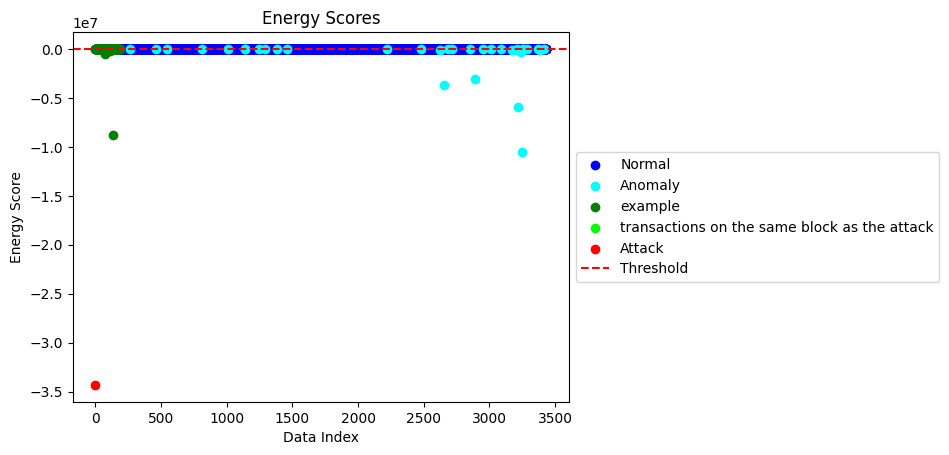

Found you
number of transactions with energy greater or equal to the attack in train is:  0  out of:  2575
number of transactions with energy greater or equal to the attack in test is:  0  out of:  859
number of transactions with energy greater or equal to the attack in example is:  0  out of:  186


In [ ]:
from sklearn import mixture



train_data, test_data = train_test_split(prep_data, test_size=0.25, random_state=40)

clf = mixture.BayesianGaussianMixture(n_components=1, covariance_type="full")
clf.fit(train_data)


# Get anomaly scores for test data
train_energy=clf.score_samples(train_data)
test_energy=clf.score_samples(test_data)
all_energy=np.concatenate((train_energy, test_energy), axis=0)

# Determine anomalies
threshold = np.percentile(all_energy, 1)
print(threshold)




normal_energy=torch.cat((torch.tensor(train_energy), torch.tensor(test_energy)), dim=0)

normal_indices = torch.where(normal_energy > threshold)[0]
anomaly_indices = torch.where(normal_energy <= threshold)[0]
attack = torch.tensor(clf.score_samples(anom.numpy()))
example = torch.tensor(clf.score_samples(exam.numpy()))

print(clf.score_samples(anom.numpy()))


plt.scatter(normal_indices, normal_energy[normal_indices], c='blue', label='Normal')
plt.scatter(anomaly_indices, normal_energy[anomaly_indices], c='cyan', label='Anomaly')
print(attack)

plt.scatter(range(len(example)), example, c='green', label='example')


plt.scatter(range(len(attack[1:3])), attack[1:3], c='lime', label='transactions on the same block as the attack')
plt.scatter(range(1), attack[0], c='red', label='Attack')
plt.axhline(y=threshold, color='r', linestyle='--', label='Threshold')
plt.title('Energy Scores')
plt.xlabel('Data Index')
plt.ylabel('Energy Score')
plt.legend(loc='center left', bbox_to_anchor=(1, 0.5))

plt.show()

if(attack[0]<=threshold):
  print("Found you")
else:
  print("try again")


print("number of transactions with energy greater or equal to the attack in train is: ", len(torch.where(torch.tensor(train_energy) <= attack[0])[0]), " out of: ", len(train_energy))
print("number of transactions with energy greater or equal to the attack in test is: ", len(torch.where(torch.tensor(test_energy) <= attack[0])[0]), " out of: ", len(test_energy))
print("number of transactions with energy greater or equal to the attack in example is: ", len(torch.where(example <= attack[0])[0]), " out of: ", len(example))